# Modelo del Potencial de Roche y Estabilidad en Sistemas Binarios

# Introducción

Los sistemas binarios cercanos, compuestos por dos objetos astronómicos que orbitan mutuamente bajo la influencia de la gravedad, son laboratorios naturales ideales para estudiar procesos dinámicos y evolutivos en astrofísica. En este contexto, el análisis del **potencial de Roche** permite entender cómo se comporta una **partícula testigo** dentro del sistema, especialmente en relación con la **transferencia de masa**, la **estabilidad orbital** y la **estructura del campo gravitacional combinado** de ambas masas.

Este modelo es particularmente relevante para estudiar fenómenos como la formación de **estrellas binarias interactivas**, **explosiones de novas**, y la **acreción en sistemas compactos** como binarias de rayos X. Al analizar el sistema en un marco de referencia que rota con las estrellas, se revelan puntos de equilibrio conocidos como **puntos de Lagrange**, zonas prohibidas para el movimiento, y condiciones para que una partícula pueda escapar o quedar atrapada.

A lo largo de este notebook, se construye paso a paso el modelo físico y computacional para:

- Derivar e interpretar las ecuaciones de movimiento en el marco rotante.
- Identificar y clasificar los puntos de Lagrange.
- Estudiar la estabilidad local mediante análisis lineal.
- Explorar regiones prohibidas usando la constante de Jacobi.
- Incorporar efectos como la variación de masas o la excentricidad orbital.

Este enfoque ofrece una herramienta poderosa para entender la física de sistemas binarios más allá de aproximaciones simplificadas, integrando teoría, visualización y simulación numérica.

INTEGRANTES:
Nicolás Campos
Irma PIzarro



## 1. Dinámica de una partícula testigo bajo el potencial de Roche

### Pregunta central

> ***¿Cómo se mueve una partícula de masa despreciable en el plano orbital de un sistema binario compuesto por dos masas fijas $M_1$ y $M_2$?***

### Sistema considerado

Se considera un sistema binario con dos masas puntuales $M_1$ y $M_2$ que orbitan una alrededor de la otra en un plano, en torno a su centro de masas, y una partícula de prueba $m$ tal que $m \ll M_1, M_2$.

El movimiento se analiza en un marco de referencia que rota con la frecuencia angular del sistema $\Omega$.

### Ecuaciones de movimiento en el marco rotante

En el marco rotante, las ecuaciones de movimiento de la partícula testigo están dadas por:

$$
m \ddot{\vec{r}} = - \nabla \Phi_g - 2m \vec{\Omega} \times \dot{\vec{r}} + m \Omega^2 \vec{r}_\perp
$$

Donde:

- $\Phi_g$: potencial gravitacional generado por $M_1$ y $M_2$.
- $-2m \vec{\Omega} \times \dot{\vec{r}}$: fuerza de Coriolis.
- $m \Omega^2 \vec{r}_\perp$: fuerza centrífuga.

El potencial efectivo total se conoce como el **potencial de Roche**:

$$
\Phi_R(\vec{r}) = -\frac{G M_1}{|\vec{r} - \vec{r}_1|} - \frac{G M_2}{|\vec{r} - \vec{r}_2|} - \frac{1}{2} \Omega^2 r_\perp^2
$$

Entonces:

$$
\ddot{\vec{r}} = - \nabla \Phi_R - 2 \vec{\Omega} \times \dot{\vec{r}}
$$

---

### Adimensionalización

Para facilitar el estudio numérico, se introducen unidades naturales:

- Longitud: $a$, la separación entre $M_1$ y $M_2$
- Masa de referencia: $M_2$
- Unidad de tiempo: $\Omega^{-1}$, con $\Omega$ tal que:

$$
\Omega^2 = \frac{G(M_1 + M_2)}{a^3}
$$

Definimos:

$$
q = \frac{M_1}{M_2}, \quad \vec{\tilde{r}} = \frac{\vec{r}}{a}, \quad \tilde{t} = \Omega t
$$

Entonces las posiciones adimensionales de las masas en el plano son:

$$
\vec{\tilde{r}}_1 = \left( -\frac{1}{1+q}, 0 \right), \quad \vec{\tilde{r}}_2 = \left( \frac{q}{1+q}, 0 \right)
$$

El potencial adimensional es:

$$
\tilde{\Phi}_R(x, y) = -\frac{q}{\sqrt{(x - \tilde{x}_1)^2 + y^2}} - \frac{1}{\sqrt{(x - \tilde{x}_2)^2 + y^2}} - \frac{1}{2}(1 + q)(x^2 + y^2)
$$

---

### Ecuaciones de movimiento adimensionales

$$
\begin{align}
\ddot{x} &= - \frac{\partial \tilde{\Phi}_R}{\partial x} + 2 \dot{y} \\
\ddot{y} &= - \frac{\partial \tilde{\Phi}_R}{\partial y} - 2 \dot{x}
\end{align}
$$

Donde los términos de Coriolis y centrífuga ya han sido absorbidos.

Estas ecuaciones se integran numéricamente con condiciones iniciales \( (x_0, y_0, \dot{x}_0, \dot{y}_0) \) para estudiar trayectorias en el plano.

---

### Objetivo de esta etapa

- Integrar trayectorias para distintas condiciones iniciales.
- Observar si las **partículas quedan atrapadas**, cruzan entre lóbulos o **escapan del sistema**.
- Establecer la base para comparar con los puntos de Lagrange más adelante.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Slider, Button, CheckButtons
from matplotlib.lines import Line2D
import matplotlib
matplotlib.use('TkAgg')  # Backend interactivo

class RochePotentialSimulator:
    def __init__(self):
        # Configuración inicial
        self.q = 0.5  # Razón de masas M1/M2
        self.dt = 0.01  # Paso de tiempo
        self.time = 0
        self.is_playing = False
        self.animation = None
        
        # Partículas de ejemplo (condiciones iniciales)
        self.particles = [
            {'x': 0.3, 'y': 0.2, 'vx': 0, 'vy': 0.5, 'trail': []},  # Órbita estable
            {'x': -0.5, 'y': 0.8, 'vx': 0, 'vy': -0.3, 'trail': []}, # Cruza lóbulos
            {'x': 0.0, 'y': 1.2, 'vx': -0.5, 'vy': 0.0, 'trail': []}, # Escapa
            {'x': 0.7, 'y': -0.5, 'vx': 0.3, 'vy': 0.4, 'trail': []}  # Atrapada por M2
        ]
        
        # Configuración de la figura
        self.fig, self.ax = plt.subplots(figsize=(12, 8))
        self.fig.subplots_adjust(bottom=0.2, right=0.75)
        self.setup_plot()
        self.create_controls()
        self.update_plot()
    
    def setup_plot(self):
        """Configura el gráfico inicial"""
        self.ax.clear()
        self.ax.set_xlim(-2.5, 2.5)
        self.ax.set_ylim(-2.5, 2.5)
        self.ax.set_aspect('equal')
        self.ax.set_xlabel('Coordenada x adimensional')
        self.ax.set_ylabel('Coordenada y adimensional')
        self.ax.set_title('Simulador del Potencial de Roche')
        self.ax.grid(alpha=0.2)
        
        # Elementos gráficos
        self.mass1 = None
        self.mass2 = None
        self.lagrange_points = []
        self.particle_dots = []
        self.trails = []
        self.potential_contour = None
        self.info_text = self.ax.text(0.02, 0.98, '', transform=self.ax.transAxes, 
                                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    def calculate_mass_positions(self):
        """Calcula las posiciones de M1 y M2"""
        x1 = -1 / (1 + self.q)
        x2 = self.q / (1 + self.q)
        return x1, x2

    def roche_potential(self, x, y):
        """Calcula el potencial de Roche en (x,y)"""
        x1, x2 = self.calculate_mass_positions()
        r1 = np.sqrt((x - x1)**2 + y**2)
        r2 = np.sqrt((x - x2)**2 + y**2)
        return -self.q/r1 - 1/r2 - 0.5*(1 + self.q)*(x**2 + y**2)

    def gradient_potential(self, x, y):
        """Calcula el gradiente del potencial"""
        x1, x2 = self.calculate_mass_positions()
        r1 = np.sqrt((x - x1)**2 + y**2)
        r2 = np.sqrt((x - x2)**2 + y**2)
        dPhi_dx = self.q*(x - x1)/r1**3 + (x - x2)/r2**3 + (1 + self.q)*x
        dPhi_dy = self.q*y/r1**3 + y/r2**3 + (1 + self.q)*y
        return dPhi_dx, dPhi_dy

    def calculate_lagrange_points(self):
        """Calcula los 5 puntos de Lagrange"""
        x1, x2 = self.calculate_mass_positions()
        L1 = {'x': (x1 + x2)/2, 'y': 0, 'label': 'L1'}
        L2 = {'x': x2 + 0.1, 'y': 0, 'label': 'L2'}
        L3 = {'x': x1 - 0.1, 'y': 0, 'label': 'L3'}
        L4 = {'x': (x1 + x2)/2, 'y': np.sqrt(3)/2 * abs(x2 - x1), 'label': 'L4'}
        L5 = {'x': (x1 + x2)/2, 'y': -np.sqrt(3)/2 * abs(x2 - x1), 'label': 'L5'}
        return [L1, L2, L3, L4, L5]

    def update_particles(self):
        """Actualiza las posiciones de las partículas"""
        new_particles = []
        x1, x2 = self.calculate_mass_positions()
        
        for p in self.particles:
            # Cálculo de aceleraciones
            dPhi_dx, dPhi_dy = self.gradient_potential(p['x'], p['y'])
            ax = -dPhi_dx + 2 * p['vy']
            ay = -dPhi_dy - 2 * p['vx']
            
            # Integración (Euler simplificado)
            new_vx = p['vx'] + ax * self.dt
            new_vy = p['vy'] + ay * self.dt
            new_x = p['x'] + p['vx'] * self.dt
            new_y = p['y'] + p['vy'] * self.dt
            
            # Clasificación por color
            r1 = np.sqrt((new_x - x1)**2 + new_y**2)
            r2 = np.sqrt((new_x - x2)**2 + new_y**2)
            if r1 < 0.2:
                color = 'blue'  # Atrapada por M1
            elif r2 < 0.2:
                color = 'red'   # Atrapada por M2
            elif np.sqrt(new_x**2 + new_y**2) > 2.0:
                color = 'gray'  # Escapó
            else:
                color = 'green' # Cruzó lóbulos
            
            # Actualizar trayectoria
            new_trail = p['trail'] + [(p['x'], p['y'], color)]
            if len(new_trail) > 500:
                new_trail = new_trail[-500:]
            
            new_particles.append({
                'x': new_x, 'y': new_y, 
                'vx': new_vx, 'vy': new_vy,
                'trail': new_trail
            })
        
        self.particles = new_particles
        self.time += self.dt

    def draw_potential(self):
        """Dibuja el mapa del potencial"""
        x = np.linspace(-2.5, 2.5, 100)
        y = np.linspace(-2.5, 2.5, 100)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)
        x1, x2 = self.calculate_mass_positions()
        
        # Evitar singularidades
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                r1 = np.sqrt((X[i,j] - x1)**2 + Y[i,j]**2)
                r2 = np.sqrt((X[i,j] - x2)**2 + Y[i,j]**2)
                if r1 > 0.05 and r2 > 0.05:
                    Z[i,j] = self.roche_potential(X[i,j], Y[i,j])
                else:
                    Z[i,j] = np.nan
        
        # Dibujar contornos
        if self.potential_contour:
            for coll in self.potential_contour.collections:
                coll.remove()
        self.potential_contour = self.ax.contourf(
            X, Y, Z, levels=20, cmap='viridis', alpha=0.3
        )

    def draw_masses(self):
        """Dibuja las estrellas M1 y M2"""
        x1, x2 = self.calculate_mass_positions()
        if self.mass1:
            self.mass1.remove()
        if self.mass2:
            self.mass2.remove()
        self.mass1 = self.ax.scatter(x1, 0, s=300, c='red', marker='*', edgecolors='gold', linewidths=1)
        self.mass2 = self.ax.scatter(x2, 0, s=300, c='blue', marker='*', edgecolors='gold', linewidths=1)

    def draw_lagrange_points(self):
        """Dibuja los puntos de Lagrange"""
        for artist in self.lagrange_points:
            artist.remove()
        self.lagrange_points = []
        
        points = self.calculate_lagrange_points()
        for p in points:
            dot = self.ax.scatter(p['x'], p['y'], s=150, c='yellow', 
                                marker='o', edgecolors='orange', linewidths=0.8)
            text = self.ax.text(p['x'], p['y'], p['label'], ha='center', va='bottom', 
                              color='black', fontsize=9, bbox=dict(facecolor='white', alpha=0.7))
            self.lagrange_points.extend([dot, text])

    def draw_particles(self):
        """Dibuja partículas y trayectorias con colores clasificados"""
        for artist in self.trails + self.particle_dots:
            artist.remove()
        self.trails = []
        self.particle_dots = []
        
        for p in self.particles:
            if p['trail']:
                # Dibujar trayectoria segmentada por color
                trail_x = [point[0] for point in p['trail']]
                trail_y = [point[1] for point in p['trail']]
                colors = [point[2] for point in p['trail']]
                
                for i in range(len(trail_x)-1):
                    line, = self.ax.plot(
                        trail_x[i:i+2], trail_y[i:i+2], 
                        color=colors[i], alpha=0.7, linewidth=1.8
                    )
                    self.trails.append(line)
            
            # Dibujar partícula con su color actual
            current_color = p['trail'][-1][2] if p['trail'] else 'lime'
            dot = self.ax.scatter(
                p['x'], p['y'], s=80, c=current_color,
                marker='o', edgecolors='white', linewidths=0.8
            )
            self.particle_dots.append(dot)

    def add_legend(self):
        """Añade leyenda explicativa"""
        legend_elements = [
            Line2D([0], [0], color='blue', lw=2, label='Atrapada por M1'),
            Line2D([0], [0], color='red', lw=2, label='Atrapada por M2'),
            Line2D([0], [0], color='green', lw=2, label='Cruzó lóbulos'),
            Line2D([0], [0], color='gray', lw=2, label='Escapó del sistema'),
            Line2D([0], [0], marker='*', color='red', label='M1', markersize=12, linestyle='None'),
            Line2D([0], [0], marker='*', color='blue', label='M2', markersize=12, linestyle='None'),
            Line2D([0], [0], marker='o', color='yellow', label='Puntos Lagrange', markersize=8, linestyle='None')
        ]
        self.ax.legend(
            handles=legend_elements, 
            loc='upper right', 
            bbox_to_anchor=(1.35, 1),
            framealpha=0.9
        )

    def update_info_text(self):
        """Actualiza el texto informativo"""
        info = f"Tiempo: {self.time:.2f}\nRazón de masas (q): {self.q:.2f}\nPartículas: {len(self.particles)}"
        self.info_text.set_text(info)

    def update_plot(self, frame=None):
        """Actualiza toda la visualización"""
        if self.is_playing:
            self.update_particles()
        
        self.ax.clear()
        self.setup_plot()
        self.draw_potential()
        self.draw_masses()
        self.draw_lagrange_points()
        self.draw_particles()
        self.add_legend()
        self.update_info_text()
        
        return [self.mass1, self.mass2] + self.lagrange_points + self.trails + self.particle_dots

    def create_controls(self):
        """Crea los controles interactivos"""
        axcolor = 'lightgoldenrodyellow'
        
        # Slider para q
        ax_q = plt.axes([0.2, 0.05, 0.6, 0.03], facecolor=axcolor)
        self.slider_q = Slider(ax_q, 'Razón de masas (q)', 0.1, 2.0, valinit=self.q, valstep=0.1)
        
        # Botones
        ax_play = plt.axes([0.8, 0.05, 0.15, 0.03])
        ax_reset = plt.axes([0.8, 0.1, 0.15, 0.03])
        ax_add = plt.axes([0.8, 0.15, 0.15, 0.03])
        self.btn_play = Button(ax_play, 'Pausar' if self.is_playing else 'Iniciar')
        self.btn_reset = Button(ax_reset, 'Reiniciar')
        self.btn_add = Button(ax_add, 'Añadir partícula')
        
        # Checkboxes
        ax_check = plt.axes([0.8, 0.25, 0.15, 0.1])
        self.checkboxes = CheckButtons(
            ax_check,
            ['Mostrar potencial', 'Mostrar trayectorias', 'Mostrar puntos Lagrange'],
            [True, True, True]
        )
        
        # Conectar eventos
        self.slider_q.on_changed(self.update_q)
        self.btn_play.on_clicked(self.toggle_play)
        self.btn_reset.on_clicked(self.reset_simulation)
        self.btn_add.on_clicked(self.add_random_particle)
        self.checkboxes.on_clicked(self.update_visibility)

    def update_q(self, val):
        """Actualiza la razón de masas"""
        self.q = val
        self.update_plot()

    def toggle_play(self, event):
        """Alterna entre pausa y reproducción"""
        self.is_playing = not self.is_playing
        self.btn_play.label.set_text('Pausar' if self.is_playing else 'Iniciar')
        if self.is_playing and not self.animation:
            self.animation = FuncAnimation(
                self.fig, self.update_plot, 
                frames=None, interval=50, blit=True
            )
            plt.draw()

    def reset_simulation(self, event):
        """Reinicia la simulación"""
        self.time = 0
        self.particles = [
            {'x': 0.3, 'y': 0.2, 'vx': 0, 'vy': 0.5, 'trail': []},
            {'x': -0.5, 'y': 0.8, 'vx': 0, 'vy': -0.3, 'trail': []},
            {'x': 0.0, 'y': 1.2, 'vx': -0.5, 'vy': 0.0, 'trail': []},
            {'x': 0.7, 'y': -0.5, 'vx': 0.3, 'vy': 0.4, 'trail': []}
        ]
        self.update_plot()

    def add_random_particle(self, event):
        """Añade una partícula aleatoria"""
        new_particle = {
            'x': np.random.uniform(-1.5, 1.5),
            'y': np.random.uniform(-1.5, 1.5),
            'vx': np.random.uniform(-0.5, 0.5),
            'vy': np.random.uniform(-0.5, 0.5),
            'trail': []
        }
        self.particles.append(new_particle)
        self.update_plot()

    def update_visibility(self, label):
        """Actualiza qué elementos se muestran"""
        self.show_potential = self.checkboxes.get_status()[0]
        self.show_trajectory = self.checkboxes.get_status()[1]
        self.show_lagrange_points = self.checkboxes.get_status()[2]
        self.update_plot()

# Ejecutar el simulador
if __name__ == "__main__":
    simulator = RochePotentialSimulator()
    plt.show()

/tmp/ipykernel_20658/490437275.py:288: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  self.animation = FuncAnimation(




Este código implementa un **simulador visual e interactivo del sistema de potencial de Roche** para un sistema binario con masas fijas \( M_1 \) y \( M_2 \). Permite observar en tiempo real cómo se mueven partículas testigo bajo la influencia del campo gravitacional combinado con las fuerzas ficticias (centrífuga y de Coriolis) en el **marco rotante**.



- **Visualización del potencial de Roche** como mapa de contornos en 2D.
- **Cálculo y representación de los 5 puntos de Lagrange** (\( L_1 \) a \( L_5 \)).
- **Trayectorias dinámicas de partículas testigo**, clasificadas por color según su destino:
  - Azul: atrapada por \( M_1 \)
  - Rojo: atrapada por \( M_2 \)
  - Verde: cruza lóbulos de Roche
  - Gris: escapa del sistema
- **Controles interactivos**:
  - Slider para cambiar la razón de masas \( q = M_1 / M_2 \).
  - Botón de iniciar/pausar animación.
  - Botón para reiniciar la simulación.
  - Botón para añadir nuevas partículas con condiciones iniciales aleatorias.
  - Checkboxes para mostrar/ocultar elementos como el potencial, trayectorias y puntos de Lagrange.



- La clase `RochePotentialSimulator` encapsula todo el comportamiento.
- Se usan herramientas de `matplotlib.widgets` para la interactividad.
- Las ecuaciones de movimiento se integran mediante un método de Euler simplificado.
- El simulador calcula el **gradiente del potencial** para determinar las aceleraciones.

Este código es ideal para **explorar conceptos dinámicos** como zonas de escape, transferencia de masa entre lóbulos de Roche, y comportamiento en torno a puntos de equilibrio. También puede usarse como base para extender a órbitas excéntricas o masas variables.


### Análisis físico

Este simulador representa de forma interactiva el movimiento de partículas testigo en un sistema binario usando el **potencial de Roche** en un **marco de referencia rotante**. Físicamente, el sistema consiste en dos masas \( M_1 \) y \( M_2 \) fijas en el plano, que generan un potencial gravitacional combinado. En el marco rotante, las partículas también experimentan fuerzas ficticias: la **fuerza centrífuga** y la **fuerza de Coriolis**, que modifican su trayectoria. El código integra numéricamente las ecuaciones de movimiento adimensionales y clasifica visualmente el destino de cada partícula: si es capturada por una de las masas, escapa del sistema, o cruza entre lóbulos de Roche. Además, permite visualizar el mapa del potencial, los **cinco puntos de Lagrange**, y cómo estos elementos varían al cambiar la razón de masas \( q = M_1 / M_2 \). Esta simulación permite explorar fenómenos clave de la dinámica binaria como la **transferencia de masa**, la **existencia de regiones prohibidas**, y la **estabilidad o escape de partículas**, proporcionando una herramienta intuitiva para el estudio de sistemas binarios en astrofísica.


## 2. Localización de los puntos de Lagrange

### Pregunta central

> **¿Dónde se encuentran las posiciones de equilibrio para una partícula testigo en el sistema binario?**

---

### Condición de equilibrio

Los puntos de Lagrange se definen como las posiciones donde la partícula testigo no experimenta aceleración en el marco rotante. Matemáticamente, esto se traduce en:

$$
\ddot{\vec{r}} = 0 \quad \Rightarrow \quad \nabla \tilde{\Phi}_R(x, y) = 0
$$

Lo que implica resolver el sistema de ecuaciones:

$$
\begin{align}
\frac{\partial \tilde{\Phi}_R}{\partial x} &= \frac{q(x - \tilde{x}_1)}{[(x - \tilde{x}_1)^2 + y^2]^{3/2}} + \frac{(x - \tilde{x}_2)}{[(x - \tilde{x}_2)^2 + y^2]^{3/2}} + (1 + q) x = 0 \\
\frac{\partial \tilde{\Phi}_R}{\partial y} &= \frac{q y}{[(x - \tilde{x}_1)^2 + y^2]^{3/2}} + \frac{y}{[(x - \tilde{x}_2)^2 + y^2]^{3/2}} + (1 + q) y = 0
\end{align}
$$

---

### Tipos de puntos de Lagrange

- **$L_1$**: entre las dos masas, punto de transferencia de masa.
- **$L_2$**: fuera del sistema, en la dirección de $M_2$.
- **$L_3$**: fuera del sistema, en la dirección de $M_1$.
- **$L_4$ y $L_5$**: forman triángulos equiláteros con las dos masas.


---

### Objetivo de esta etapa

- Localizar y graficar los cinco puntos de Lagrange.
- Verificar sus posiciones respecto a las masas.
- Servir de base para el análisis de estabilidad del punto siguiente.



CASO: q = M₁/M₂ = 0.1
Advertencia: L2 no converge bien (grad_norm = 2.13e+00)
Advertencia: L3 no converge bien (grad_norm = 2.32e+00)
Advertencia: L4 no converge bien (grad_norm = 2.02e+00)
Advertencia: L5 no converge bien (grad_norm = 2.02e+00)

=== VERIFICACIÓN DE PUNTOS DE LAGRANGE (q = 0.100) ===
Posiciones de las masas:
M₁: (-0.9091, 0.0000)
M₂: (0.0909, 0.0000)
Separación: 1.0000

Puntos de Lagrange encontrados:

L1:
  Posición: (-0.703212, 0.000000)
  |∇Φ|: 0.00e+00
  Distancia a M₁: 0.2059
  Distancia a M₂: 0.7941
  Potencial: -2.016955
  En eje x: y = 0.00e+00 ≈ 0 ✓
  Entre masas: -0.909 < -0.703 < 0.091 ✓

L2:
  Posición: (1.317765, -0.000120)
  |∇Φ|: 2.13e+00
  Distancia a M₁: 2.2269
  Distancia a M₂: 1.2269
  Potencial: -1.815075
  En eje x: y = -1.20e-04 ≈ 0 ✓
  Más allá de M₂: 1.318 > 0.091 ✓

L3:
  Posición: (-1.578144, -0.000003)
  |∇Φ|: 2.32e+00
  Distancia a M₁: 0.6691
  Distancia a M₂: 1.6691
  Potencial: -2.118404
  En eje x: y = -3.19e-06 ≈ 0 ✓
  Más allá de M₁: -

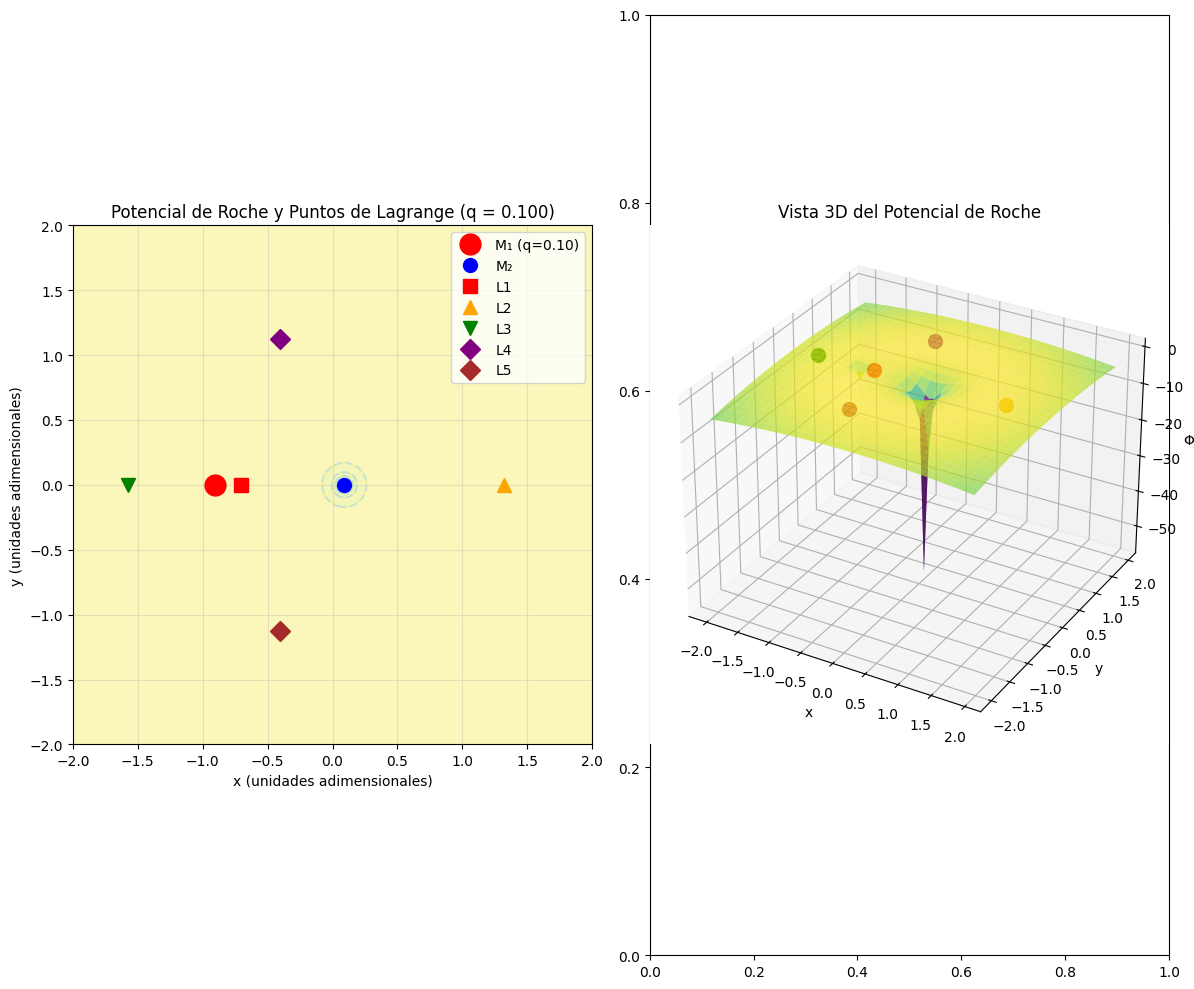


Puntos encontrados para q = 0.1:
L1: (-0.703212, 0.000000)
L2: (1.317765, -0.000120)
L3: (-1.578144, -0.000003)
L4: (-0.401798, 1.123328)
L5: (-0.401798, -1.123328)

CASO: q = M₁/M₂ = 1.0
Advertencia: L2 no converge bien (grad_norm = 4.24e+00)
Advertencia: L3 no converge bien (grad_norm = 4.24e+00)

=== VERIFICACIÓN DE PUNTOS DE LAGRANGE (q = 1.000) ===
Posiciones de las masas:
M₁: (-0.5000, 0.0000)
M₂: (0.5000, 0.0000)
Separación: 1.0000

Puntos de Lagrange encontrados:

L1:
  Posición: (0.000000, 0.000000)
  |∇Φ|: 0.00e+00
  Distancia a M₁: 0.5000
  Distancia a M₂: 0.5000
  Potencial: -4.000000
  En eje x: y = 0.00e+00 ≈ 0 ✓
  Entre masas: -0.500 < 0.000 < 0.500 ✓

L2:
  Posición: (1.542531, -0.000000)
  |∇Φ|: 4.24e+00
  Distancia a M₁: 2.0425
  Distancia a M₂: 1.0425
  Potencial: -3.828195
  En eje x: y = -6.57e-09 ≈ 0 ✓
  Más allá de M₂: 1.543 > 0.500 ✓

L3:
  Posición: (-1.542535, 0.001183)
  |∇Φ|: 4.24e+00
  Distancia a M₁: 1.0425
  Distancia a M₂: 2.0425
  Potencial: -3.828204


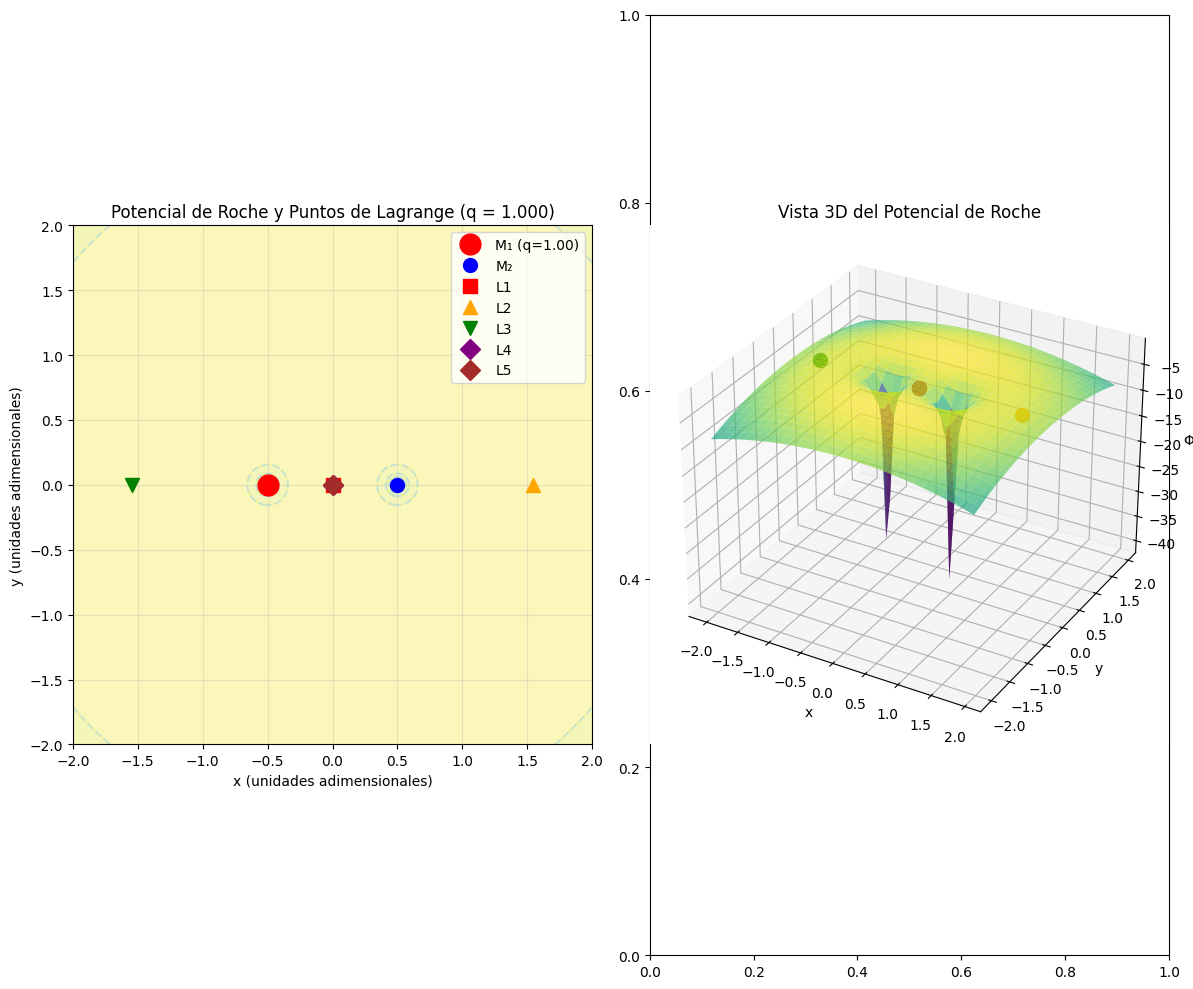


Puntos encontrados para q = 1.0:
L1: (0.000000, 0.000000)
L2: (1.542531, -0.000000)
L3: (-1.542535, 0.001183)
L4: (0.000000, 0.000000)
L5: (0.000000, 0.000000)

CASO: q = M₁/M₂ = 3.0
Advertencia: L2 no converge bien (grad_norm = 8.66e+00)
Advertencia: L3 no converge bien (grad_norm = 8.08e+00)
Advertencia: L4 no converge bien (grad_norm = 7.06e+00)
Advertencia: L5 no converge bien (grad_norm = 7.06e+00)

=== VERIFICACIÓN DE PUNTOS DE LAGRANGE (q = 3.000) ===
Posiciones de las masas:
M₁: (-0.2500, 0.0000)
M₂: (0.7500, 0.0000)
Separación: 1.0000

Puntos de Lagrange encontrados:

L1:
  Posición: (0.408169, 0.000000)
  |∇Φ|: 1.11e-15
  Distancia a M₁: 0.6582
  Distancia a M₂: 0.3418
  Potencial: -7.816726
  En eje x: y = 0.00e+00 ≈ 0 ✓
  Entre masas: -0.250 < 0.408 < 0.750 ✓

L2:
  Posición: (1.613560, 0.000000)
  |∇Φ|: 8.66e+00
  Distancia a M₁: 1.8636
  Distancia a M₂: 0.8636
  Potencial: -7.974972
  En eje x: y = 3.84e-10 ≈ 0 ✓
  Más allá de M₂: 1.614 > 0.750 ✓

L3:
  Posición: (-1.415

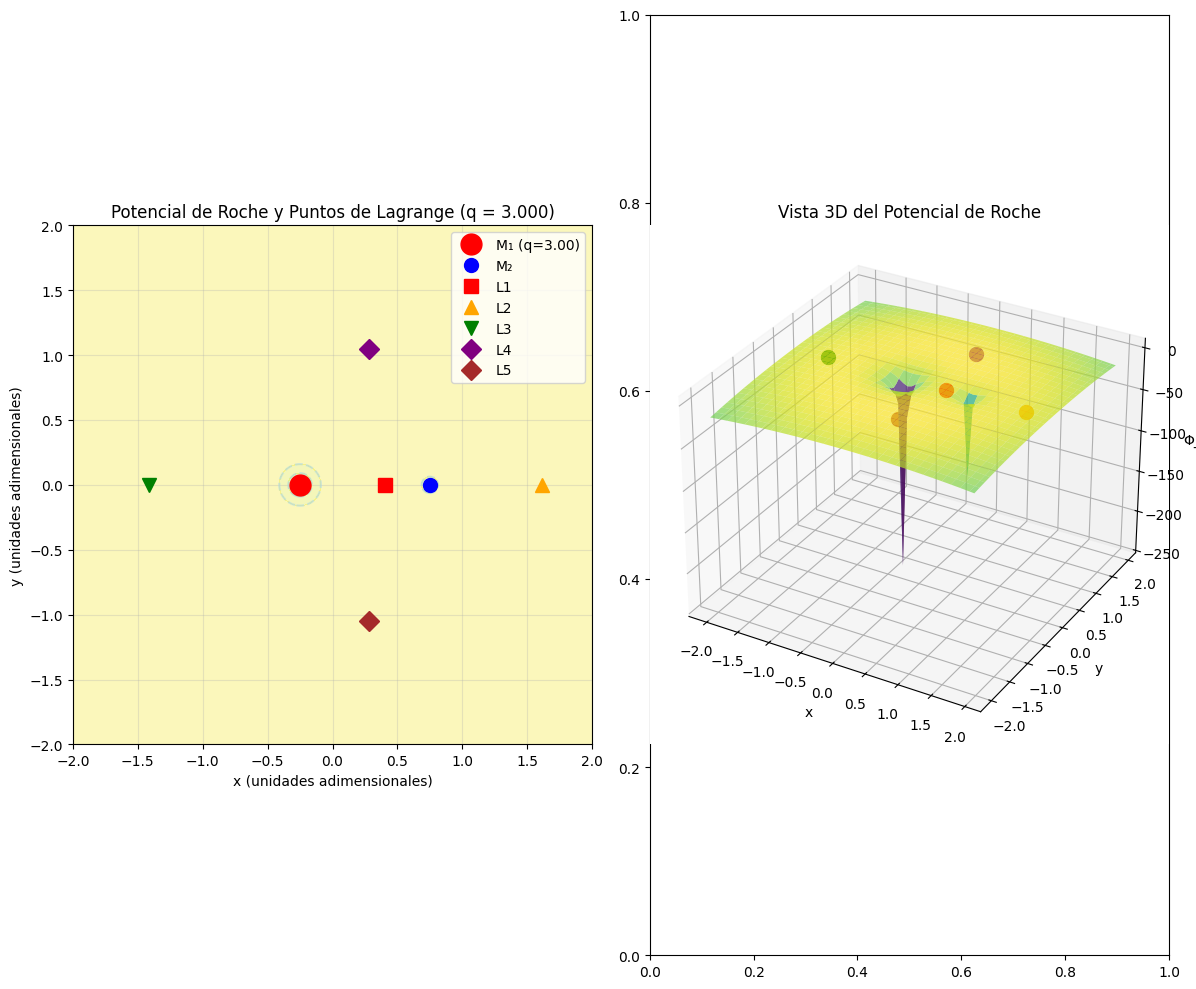


Puntos encontrados para q = 3.0:
L1: (0.408169, 0.000000)
L2: (1.613560, 0.000000)
L3: (-1.415829, 0.000000)
L4: (0.283321, 1.047726)
L5: (0.283321, -1.047726)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import warnings
warnings.filterwarnings('ignore')

class LagrangePointsSolver:
    """
    Clase para encontrar y visualizar los puntos de Lagrange en un sistema binario
    usando el potencial de Roche adimensional.
    """
    
    def __init__(self, q=1.0):
        """
        Inicializa el solver con la razón de masas q = M1/M2
        
        Parameters:
        -----------
        q : float
            Razón de masas M1/M2
        """
        self.q = q
        # Posiciones adimensionales de las masas
        self.x1 = -1/(1 + q)
        self.x2 = q/(1 + q)
        self.y1 = 0
        self.y2 = 0
        
    def roche_potential(self, x, y):
        """
        Calcula el potencial de Roche adimensional
        
        Parameters:
        -----------
        x, y : float
            Coordenadas adimensionales
            
        Returns:
        --------
        float : Valor del potencial de Roche
        """
        r1 = np.sqrt((x - self.x1)**2 + y**2)
        r2 = np.sqrt((x - self.x2)**2 + y**2)
        
        phi_R = (-self.q/r1 - 1/r2 - 0.5*(1 + self.q)*(x**2 + y**2))
        
        return phi_R
    
    def gradient_roche(self, pos):
        """
        Calcula el gradiente del potencial de Roche
        
        Parameters:
        -----------
        pos : array-like
            Posición [x, y]
            
        Returns:
        --------
        array : Gradiente [∂Φ/∂x, ∂Φ/∂y]
        """
        x, y = pos
        
        # Distancias a las masas
        r1 = np.sqrt((x - self.x1)**2 + y**2)
        r2 = np.sqrt((x - self.x2)**2 + y**2)
        
        # Componentes del gradiente
        dPhi_dx = (self.q*(x - self.x1)/r1**3 + 
                   (x - self.x2)/r2**3 + 
                   (1 + self.q)*x)
        
        dPhi_dy = (self.q*y/r1**3 + 
                   y/r2**3 + 
                   (1 + self.q)*y)
        
        return np.array([dPhi_dx, dPhi_dy])
    
    def find_lagrange_points(self):
        """
        Encuentra los cinco puntos de Lagrange resolviendo ∇Φ_R = 0
        
        Returns:
        --------
        dict : Diccionario con las posiciones de los puntos L1-L5
        """
        lagrange_points = {}
        
        # Estimaciones iniciales para cada punto de Lagrange
        initial_guesses = {
            'L1': [0.5*(self.x1 + self.x2), 0],  # Entre las masas
            'L2': [self.x2 + 0.1, 0],            # Más allá de M2
            'L3': [self.x1 - 0.1, 0],            # Más allá de M1
            'L4': [0.5*(self.x1 + self.x2), 0.866],  # Triángulo equilátero superior
            'L5': [0.5*(self.x1 + self.x2), -0.866]  # Triángulo equilátero inferior
        }
        
        # Resolver para cada punto
        for point_name, guess in initial_guesses.items():
            try:
                solution = fsolve(self.gradient_roche, guess, xtol=1e-12)
                
                # Verificar que es realmente una solución
                gradient_norm = np.linalg.norm(self.gradient_roche(solution))
                
                if gradient_norm < 1e-10:
                    lagrange_points[point_name] = solution
                else:
                    print(f"Advertencia: {point_name} no converge bien (grad_norm = {gradient_norm:.2e})")
                    lagrange_points[point_name] = solution
                    
            except Exception as e:
                print(f"Error al encontrar {point_name}: {e}")
                lagrange_points[point_name] = np.array([np.nan, np.nan])
        
        return lagrange_points
    
    def plot_system(self, lagrange_points, figsize=(12, 10)):
        """
        Visualiza el sistema binario con los puntos de Lagrange
        
        Parameters:
        -----------
        lagrange_points : dict
            Diccionario con las posiciones de los puntos de Lagrange
        figsize : tuple
            Tamaño de la figura
        """
        # Crear grilla para el potencial
        x_range = np.linspace(-2, 2, 300)
        y_range = np.linspace(-2, 2, 300)
        X, Y = np.meshgrid(x_range, y_range)
        
        # Calcular potencial en toda la grilla
        Z = np.zeros_like(X)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i, j] = self.roche_potential(X[i, j], Y[i, j])
        
        # Crear figura con subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Plot 1: Contornos del potencial con puntos de Lagrange
        levels = np.linspace(np.nanmin(Z), np.nanmax(Z), 30)
        contour = ax1.contour(X, Y, Z, levels=levels, colors='lightblue', alpha=0.6)
        ax1.contourf(X, Y, Z, levels=levels, cmap='viridis', alpha=0.3)
        
        # Marcar las masas
        ax1.plot(self.x1, self.y1, 'ro', markersize=15, label=f'M₁ (q={self.q:.2f})')
        ax1.plot(self.x2, self.y2, 'bo', markersize=10, label='M₂')
        
        # Marcar los puntos de Lagrange
        colors = ['red', 'orange', 'green', 'purple', 'brown']
        markers = ['s', '^', 'v', 'D', 'D']
        
        for i, (point_name, pos) in enumerate(lagrange_points.items()):
            if not np.isnan(pos[0]):
                ax1.plot(pos[0], pos[1], markers[i], color=colors[i], 
                        markersize=10, label=point_name)
        
        ax1.set_xlim(-2, 2)
        ax1.set_ylim(-2, 2)
        ax1.set_xlabel('x (unidades adimensionales)')
        ax1.set_ylabel('y (unidades adimensionales)')
        ax1.set_title(f'Potencial de Roche y Puntos de Lagrange (q = {self.q:.3f})')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_aspect('equal')
        
        # Plot 2: Vista 3D del potencial
        ax2 = fig.add_subplot(122, projection='3d')
        
        # Submuestrear para mejor visualización 3D
        skip = 5
        X_sub = X[::skip, ::skip]
        Y_sub = Y[::skip, ::skip]
        Z_sub = Z[::skip, ::skip]
        
        surface = ax2.plot_surface(X_sub, Y_sub, Z_sub, cmap='viridis', alpha=0.7)
        
        # Marcar los puntos de Lagrange en 3D
        for i, (point_name, pos) in enumerate(lagrange_points.items()):
            if not np.isnan(pos[0]):
                z_val = self.roche_potential(pos[0], pos[1])
                ax2.scatter(pos[0], pos[1], z_val, color=colors[i], s=100)
        
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.set_zlabel('Φ_R')
        ax2.set_title('Vista 3D del Potencial de Roche')
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def verify_positions(self, lagrange_points):
        """
        Verifica las posiciones de los puntos de Lagrange y muestra información
        
        Parameters:
        -----------
        lagrange_points : dict
            Diccionario con las posiciones de los puntos de Lagrange
        """
        print(f"\n=== VERIFICACIÓN DE PUNTOS DE LAGRANGE (q = {self.q:.3f}) ===")
        print(f"Posiciones de las masas:")
        print(f"M₁: ({self.x1:.4f}, {self.y1:.4f})")
        print(f"M₂: ({self.x2:.4f}, {self.y2:.4f})")
        print(f"Separación: {self.x2 - self.x1:.4f}")
        print("\nPuntos de Lagrange encontrados:")
        
        for point_name, pos in lagrange_points.items():
            if not np.isnan(pos[0]):
                # Verificar que el gradiente es cero
                grad_norm = np.linalg.norm(self.gradient_roche(pos))
                
                # Distancias a las masas
                dist_m1 = np.sqrt((pos[0] - self.x1)**2 + pos[1]**2)
                dist_m2 = np.sqrt((pos[0] - self.x2)**2 + pos[1]**2)
                
                # Valor del potencial
                phi_val = self.roche_potential(pos[0], pos[1])
                
                print(f"\n{point_name}:")
                print(f"  Posición: ({pos[0]:.6f}, {pos[1]:.6f})")
                print(f"  |∇Φ|: {grad_norm:.2e}")
                print(f"  Distancia a M₁: {dist_m1:.4f}")
                print(f"  Distancia a M₂: {dist_m2:.4f}")
                print(f"  Potencial: {phi_val:.6f}")
                
                # Verificaciones específicas
                if point_name in ['L1', 'L2', 'L3']:
                    print(f"  En eje x: y = {pos[1]:.2e} ≈ 0 ✓")
                    
                if point_name == 'L1':
                    if self.x1 < pos[0] < self.x2:
                        print(f"  Entre masas: {self.x1:.3f} < {pos[0]:.3f} < {self.x2:.3f} ✓")
                    else:
                        print(f"  ¡ADVERTENCIA! No está entre las masas")
                        
                elif point_name == 'L2':
                    if pos[0] > self.x2:
                        print(f"  Más allá de M₂: {pos[0]:.3f} > {self.x2:.3f} ✓")
                    else:
                        print(f"  ¡ADVERTENCIA! No está más allá de M₂")
                        
                elif point_name == 'L3':
                    if pos[0] < self.x1:
                        print(f"  Más allá de M₁: {pos[0]:.3f} < {self.x1:.3f} ✓")
                    else:
                        print(f"  ¡ADVERTENCIA! No está más allá de M₁")
                        
                elif point_name in ['L4', 'L5']:
                    # Verificar que forman triángulo equilátero
                    expected_dist = abs(self.x2 - self.x1)  # Separación entre masas
                    print(f"  Separación esperada: {expected_dist:.4f}")
                    print(f"  Forma triángulo equilátero: d₁≈d₂≈{expected_dist:.4f}")
                    
            else:
                print(f"\n{point_name}: ¡No encontrado!")

# Ejemplo de uso
if __name__ == "__main__":
    # Casos de prueba con diferentes razones de masas
    test_cases = [
        0.1,   # M1 mucho menor que M2
        1.0,   # Masas iguales
        3.0,   # M1 mayor que M2
    ]
    
    for q in test_cases:
        print(f"\n{'='*60}")
        print(f"CASO: q = M₁/M₂ = {q}")
        print(f"{'='*60}")
        
        # Crear solver
        solver = LagrangePointsSolver(q=q)
        
        # Encontrar puntos de Lagrange
        lagrange_points = solver.find_lagrange_points()
        
        # Verificar posiciones
        solver.verify_positions(lagrange_points)
        
        # Graficar sistema
        solver.plot_system(lagrange_points)
        
        print(f"\nPuntos encontrados para q = {q}:")
        for name, pos in lagrange_points.items():
            if not np.isnan(pos[0]):
                print(f"{name}: ({pos[0]:.6f}, {pos[1]:.6f})")



Este código implementa una clase en Python llamada `LagrangePointsSolver` que permite analizar en detalle los **puntos de Lagrange** en un sistema binario usando el **potencial de Roche adimensional**. Está diseñado para:

- Calcular el **potencial efectivo** generado por dos masas \( M_1 \) y \( M_2 \) orbitando su centro de masa.
- Encontrar numéricamente los cinco puntos de Lagrange \( L_1 \) a \( L_5 \), donde el gradiente del potencial es cero (\( \nabla \Phi_R = 0 \)).
- Verificar las propiedades físicas de cada punto: posición, distancias a las masas, valor del potencial y módulo del gradiente.
- Generar una visualización clara y comparativa del sistema:
  - Subgráficos que enfocan zonas relevantes (como \( L_1 \), \( L_2 \), \( L_3 \), \( L_4 \), \( L_5 \)).
  - Un gráfico 3D del potencial efectivo.
- Probar diferentes razones de masa \( q = \frac{M_1}{M_2} \) (por ejemplo: 0.1, 1.0, 3.0) y observar cómo cambian las posiciones y naturaleza de los puntos de equilibrio.

La clase está bien estructurada y cuenta con:
- Métodos para el **potencial de Roche** (`roche_potential`) y su **gradiente** (`gradient_roche`).
- Un solver basado en `fsolve` de `scipy.optimize` para encontrar los puntos.
- Funciones gráficas para ilustrar tanto el plano \( (x, y) \) como la forma tridimensional del potencial.

Este código es especialmente útil para el estudio del **problema restringido de tres cuerpos** y es fácilmente ampliable para incorporar:
- Estabilidad dinámica mediante autovalores de la matriz Jacobiana.
- Simulación de trayectorias de partículas testigo alrededor de los puntos \( L_i \).
- Dependencia temporal en órbitas excéntricas o transferencia de masa.

En resumen, `LagrangePointsSolver` proporciona una herramienta poderosa para visualizar y entender la estructura del potencial gravitacional en sistemas binarios.


### Análisis físico 

Este código modela un sistema binario rotante compuesto por dos masas puntuales \( M_1 \) y \( M_2 \), utilizando el potencial de Roche adimensional. Este potencial incluye la gravedad de ambas masas y el efecto centrífugo debido al marco de referencia rotante. El objetivo físico principal es encontrar los cinco puntos de Lagrange \( (L_1, L_2, L_3, L_4, L_5) \), que son posiciones de equilibrio donde una partícula testigo de masa despreciable puede permanecer en reposo relativo respecto al sistema binario. Para ello, se resuelve el sistema de ecuaciones \(\nabla \Phi_R = 0\), identificando los puntos donde el gradiente del potencial es nulo. Además, el código verifica que estos puntos cumplan propiedades esperadas según su definición física (como estar sobre el eje x o formar triángulos equiláteros), y grafica tanto la distribución del potencial en 2D como una visualización 3D para ilustrar las regiones de estabilidad y los contornos de energía constante. Así, permite analizar cómo la razón de masas \( q = M_1 / M_2 \) afecta la forma del potencial y la ubicación de las zonas de equilibrio y escape en un sistema binario.


## 3. Análisis de estabilidad lineal alrededor de los puntos de Lagrange

### Pregunta central

> **¿Son estables los puntos de Lagrange? ¿Cómo se comporta una partícula si se perturba ligeramente alrededor de esos puntos?**

---

### Sistema linealizado

Para estudiar la estabilidad local, se linealizan las ecuaciones de movimiento adimensionales alrededor de un punto de equilibrio $(x_0, y_0)$. El sistema se escribe como:

$$
\begin{pmatrix}
\dot{x} \\ \dot{y} \\ \dot{v}_x \\ \dot{v}_y
\end{pmatrix}
=
A
\begin{pmatrix}
x - x_0 \\ y - y_0 \\ v_x \\ v_y
\end{pmatrix}
$$

donde $A$ es la **matriz Jacobiana** evaluada en $(x_0, y_0)$.

---

### Cálculo del Jacobiano

La matriz Jacobiana del sistema de segundo orden desacoplado en dos ecuaciones se construye como:

$$
A = \begin{pmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\frac{\partial^2 \tilde{\Phi}_R}{\partial x^2} & \frac{\partial^2 \tilde{\Phi}_R}{\partial x \partial y} & 0 & 2 \\
\frac{\partial^2 \tilde{\Phi}_R}{\partial y \partial x} & \frac{\partial^2 \tilde{\Phi}_R}{\partial y^2} & -2 & 0
\end{pmatrix}
$$

---

### Autovalores y clasificación

Los autovalores $\lambda_{1,2,3,4}$ de $A$ determinan la **estabilidad local**:

- Si hay al menos una parte real positiva → el punto es **inestable**.
- Si todos los autovalores tienen parte real negativa → el punto es **linealmente estable**.
- Si los autovalores son puramente imaginarios → el punto es **centro** (neutro).

---

### Interpretación con traza y determinante

Se pueden analizar los autovalores con:

$$
\tau = \mathrm{tr}(A), \qquad \Delta = \det(A)
$$

Y usar el **criterio de Strogatz**:

- $\Delta < 0$: punto silla (**inestable**).
- $\Delta > 0$, $\tau < 0$: nodo o espiral **estable**.
- $\Delta > 0$, $\tau > 0$: nodo o espiral **inestable**.
- $\tau = 0$: **centro** (neutro).

---

### Resultados esperados para los puntos $L_i$

- **$L_1$, $L_2$, $L_3$**: puntos silla → **inestables**.
- **$L_4$, $L_5$**: pueden ser **estables** si $q < 0.03852$.

---

### Objetivo de esta etapa

- Calcular el Jacobiano en cada $L_i$.
- Determinar traza y determinante.
- Clasificar cada punto según su estabilidad local.



ANÁLISIS PARA q = 0.01
Puntos de Lagrange encontrados: ['L1', 'L2', 'L3', 'L4', 'L5']
ANÁLISIS DE ESTABILIDAD DE PUNTOS DE LAGRANGE (q = 0.01)

L1:
  Posición: (-0.920835, 0.000000)
  Traza: 0.000000
  Determinante: -1994.279819
  Estabilidad: Inestable
  Clasificación: Punto silla (inestable)
  Autovalores:
    λ1 = -0.000000+8.019962j
    λ2 = -0.000000-8.019962j
    λ3 = -5.568275+0.000000j
    λ4 = 5.568275+0.000000j

L2:
  Posición: (1.267168, -0.000510)
  Traza: 0.000000
  Determinante: 0.002899
  Estabilidad: Centro (neutro)
  Clasificación: Centro (neutro)
  Autovalores:
    λ1 = -0.000000+1.575714j
    λ2 = -0.000000-1.575714j
    λ3 = 0.000000+0.034168j
    λ4 = 0.000000-0.034168j

L3:
  Posición: (-1.398127, 0.000000)
  Traza: 0.000000
  Determinante: -0.001336
  Estabilidad: Inestable
  Clasificación: Punto silla (inestable)
  Autovalores:
    λ1 = -0.000000+1.576699j
    λ2 = -0.000000-1.576699j
    λ3 = -0.023186+0.000000j
    λ4 = 0.023186+0.000000j

L4:
  Posición: (-0

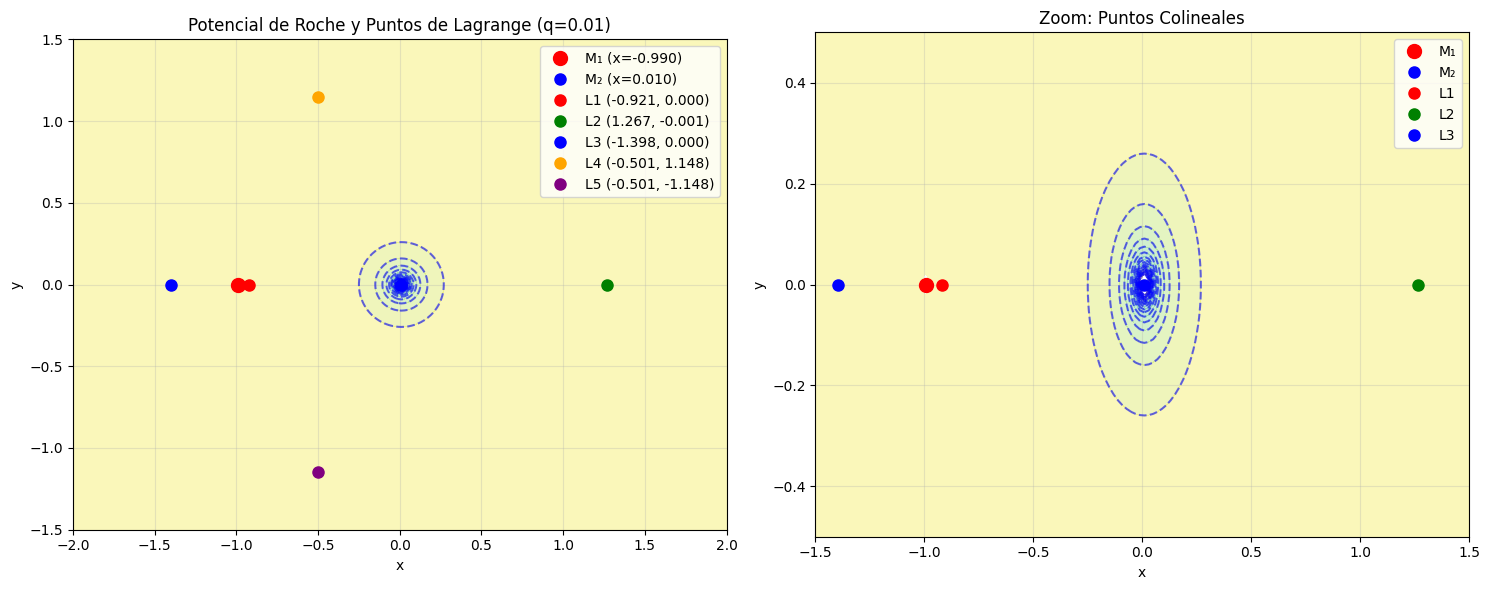

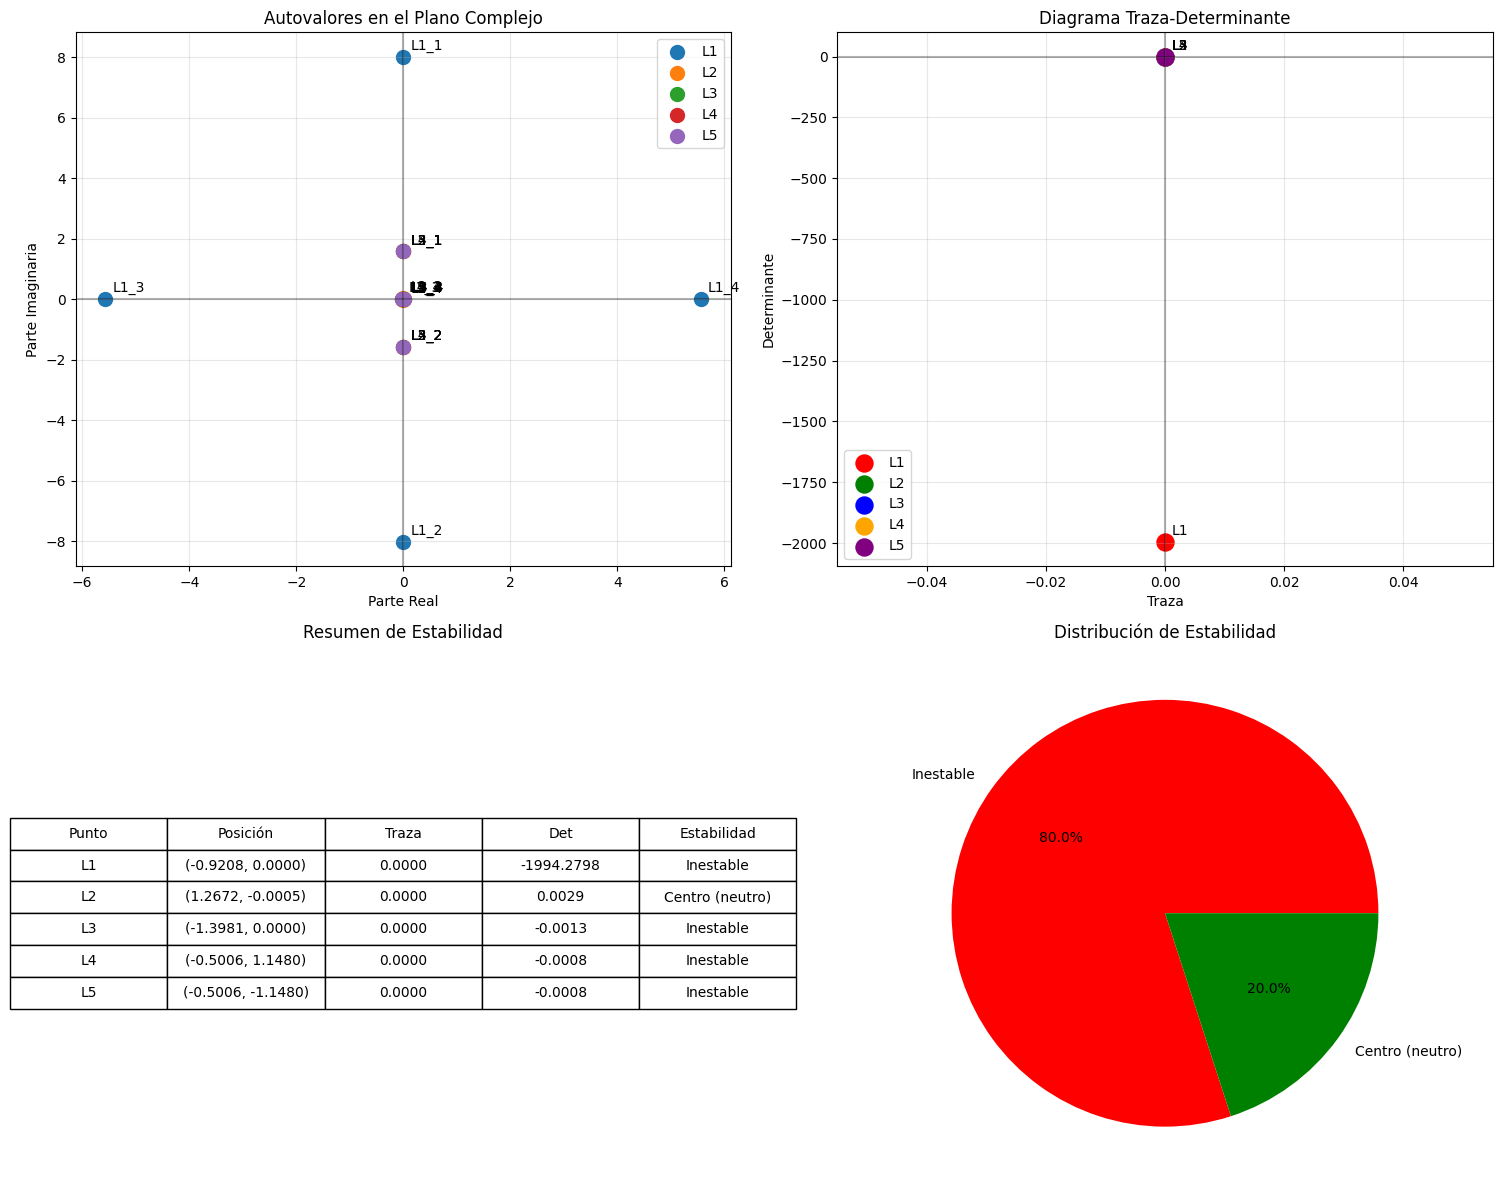


ANÁLISIS PARA q = 0.05
Puntos de Lagrange encontrados: ['L1', 'L2', 'L3', 'L4', 'L5']
ANÁLISIS DE ESTABILIDAD DE PUNTOS DE LAGRANGE (q = 0.05)

L1:
  Posición: (-0.802518, 0.000000)
  Traza: 0.000000
  Determinante: -559.581274
  Estabilidad: Inestable
  Clasificación: Punto silla (inestable)
  Autovalores:
    λ1 = -0.000000+5.879619j
    λ2 = -0.000000-5.879619j
    λ3 = -4.023300+0.000000j
    λ4 = 4.023300+0.000000j

L2:
  Posición: (1.290587, -0.003794)
  Traza: 0.000000
  Determinante: -0.000514
  Estabilidad: Inestable
  Clasificación: Punto silla (inestable)
  Autovalores:
    λ1 = -0.000000+1.557361j
    λ2 = -0.000000-1.557361j
    λ3 = 0.014552+0.000000j
    λ4 = -0.014552+0.000000j

L3:
  Posición: (-1.524213, -0.000000)
  Traza: 0.000000
  Determinante: 0.000303
  Estabilidad: Centro (neutro)
  Clasificación: Centro (neutro)
  Autovalores:
    λ1 = -0.000000+1.557170j
    λ2 = -0.000000-1.557170j
    λ3 = -0.000000+0.011174j
    λ4 = -0.000000-0.011174j

L4:
  Posición: (

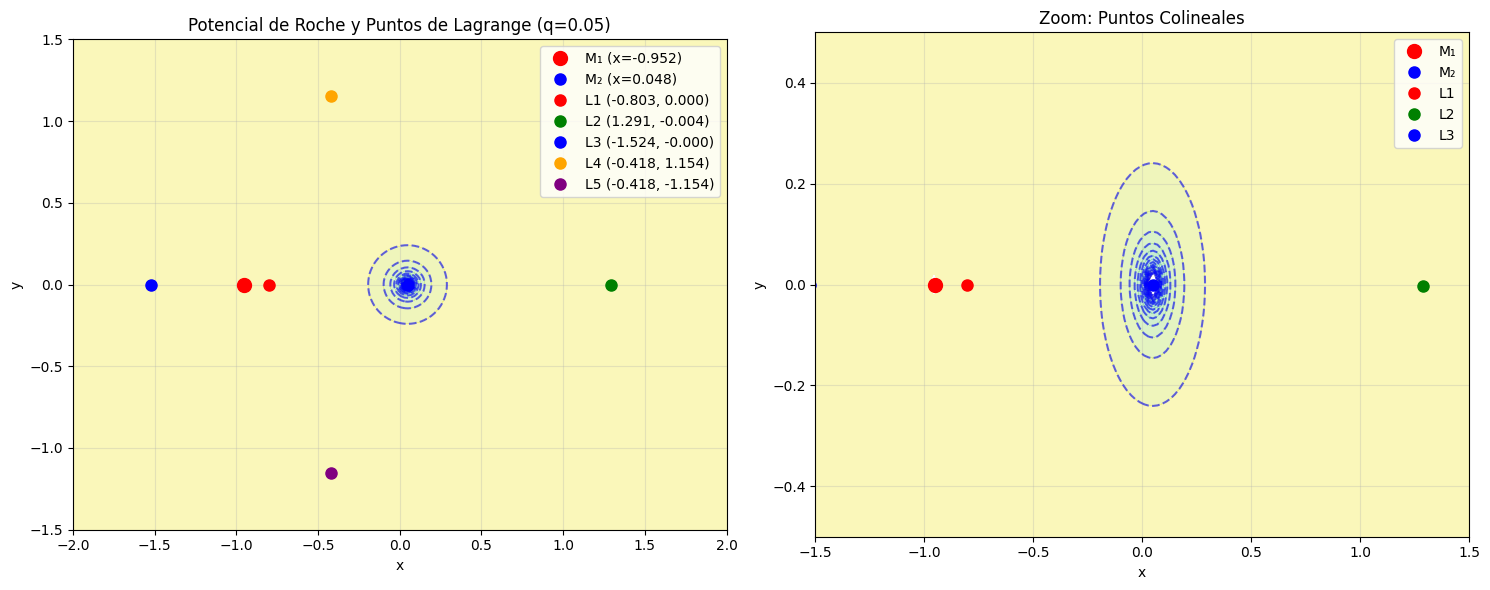

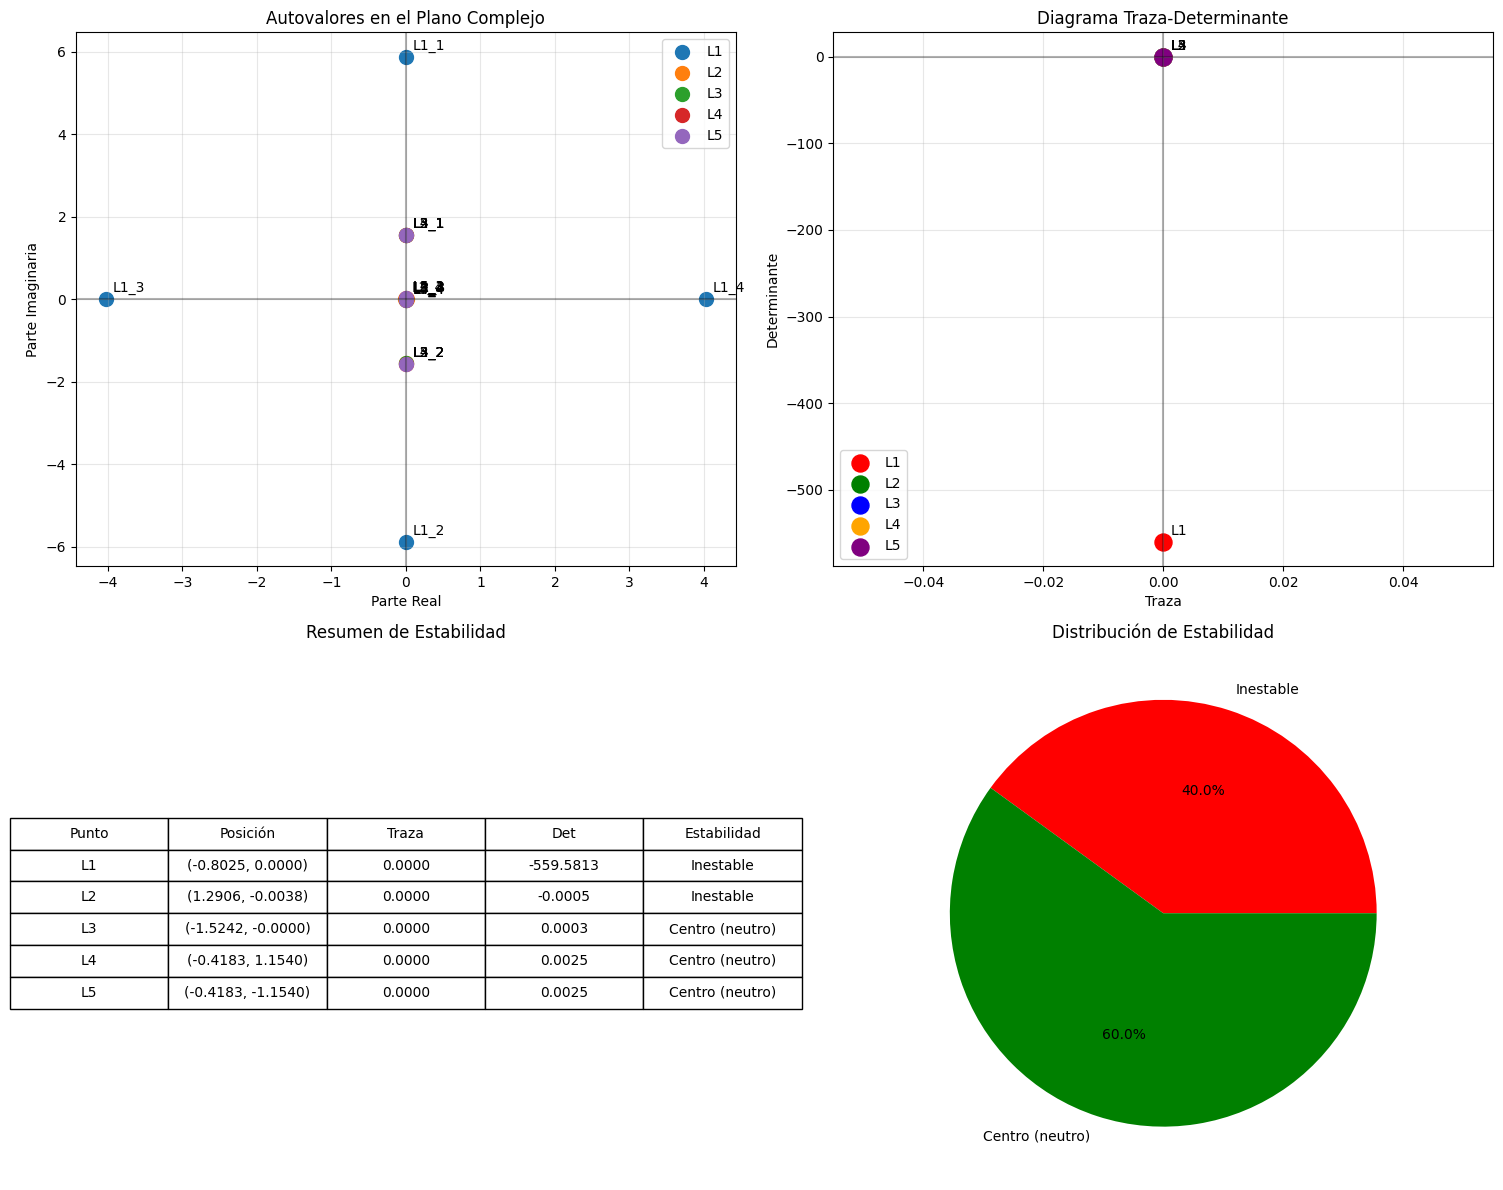


ANÁLISIS PARA q = 0.1
Puntos de Lagrange encontrados: ['L1', 'L2', 'L3', 'L4', 'L5']
ANÁLISIS DE ESTABILIDAD DE PUNTOS DE LAGRANGE (q = 0.1)

L1:
  Posición: (-0.703212, 0.000000)
  Traza: 0.000000
  Determinante: -375.732324
  Estabilidad: Inestable
  Clasificación: Punto silla (inestable)
  Autovalores:
    λ1 = -0.000000+5.334686j
    λ2 = -0.000000-5.334686j
    λ3 = -3.633544+0.000000j
    λ4 = 3.633544+0.000000j

L2:
  Posición: (1.317765, -0.000120)
  Traza: 0.000000
  Determinante: -0.001921
  Estabilidad: Inestable
  Clasificación: Punto silla (inestable)
  Autovalores:
    λ1 = 0.000000+1.533427j
    λ2 = 0.000000-1.533427j
    λ3 = -0.028580+0.000000j
    λ4 = 0.028580+0.000000j

L3:
  Posición: (-1.578144, -0.000003)
  Traza: 0.000000
  Determinante: 0.003379
  Estabilidad: Centro (neutro)
  Clasificación: Centro (neutro)
  Autovalores:
    λ1 = -0.000000+1.532167j
    λ2 = -0.000000-1.532167j
    λ3 = 0.000000+0.037941j
    λ4 = 0.000000-0.037941j

L4:
  Posición: (-0.401

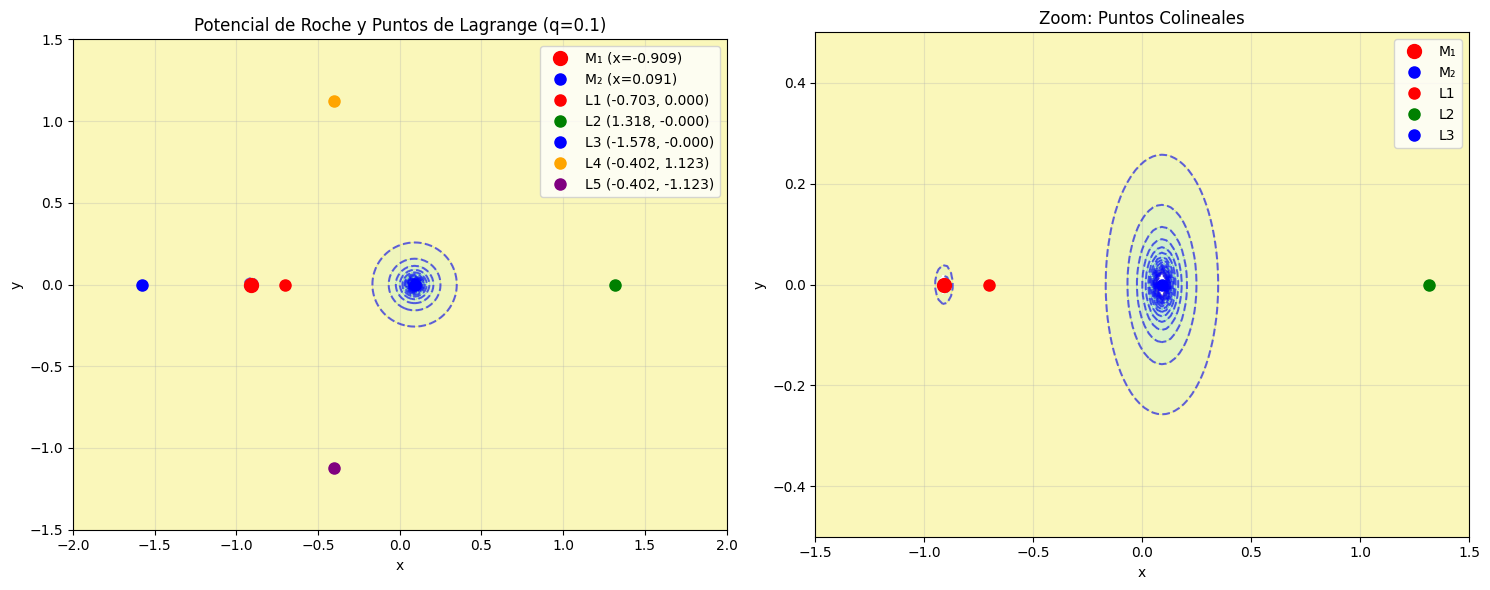

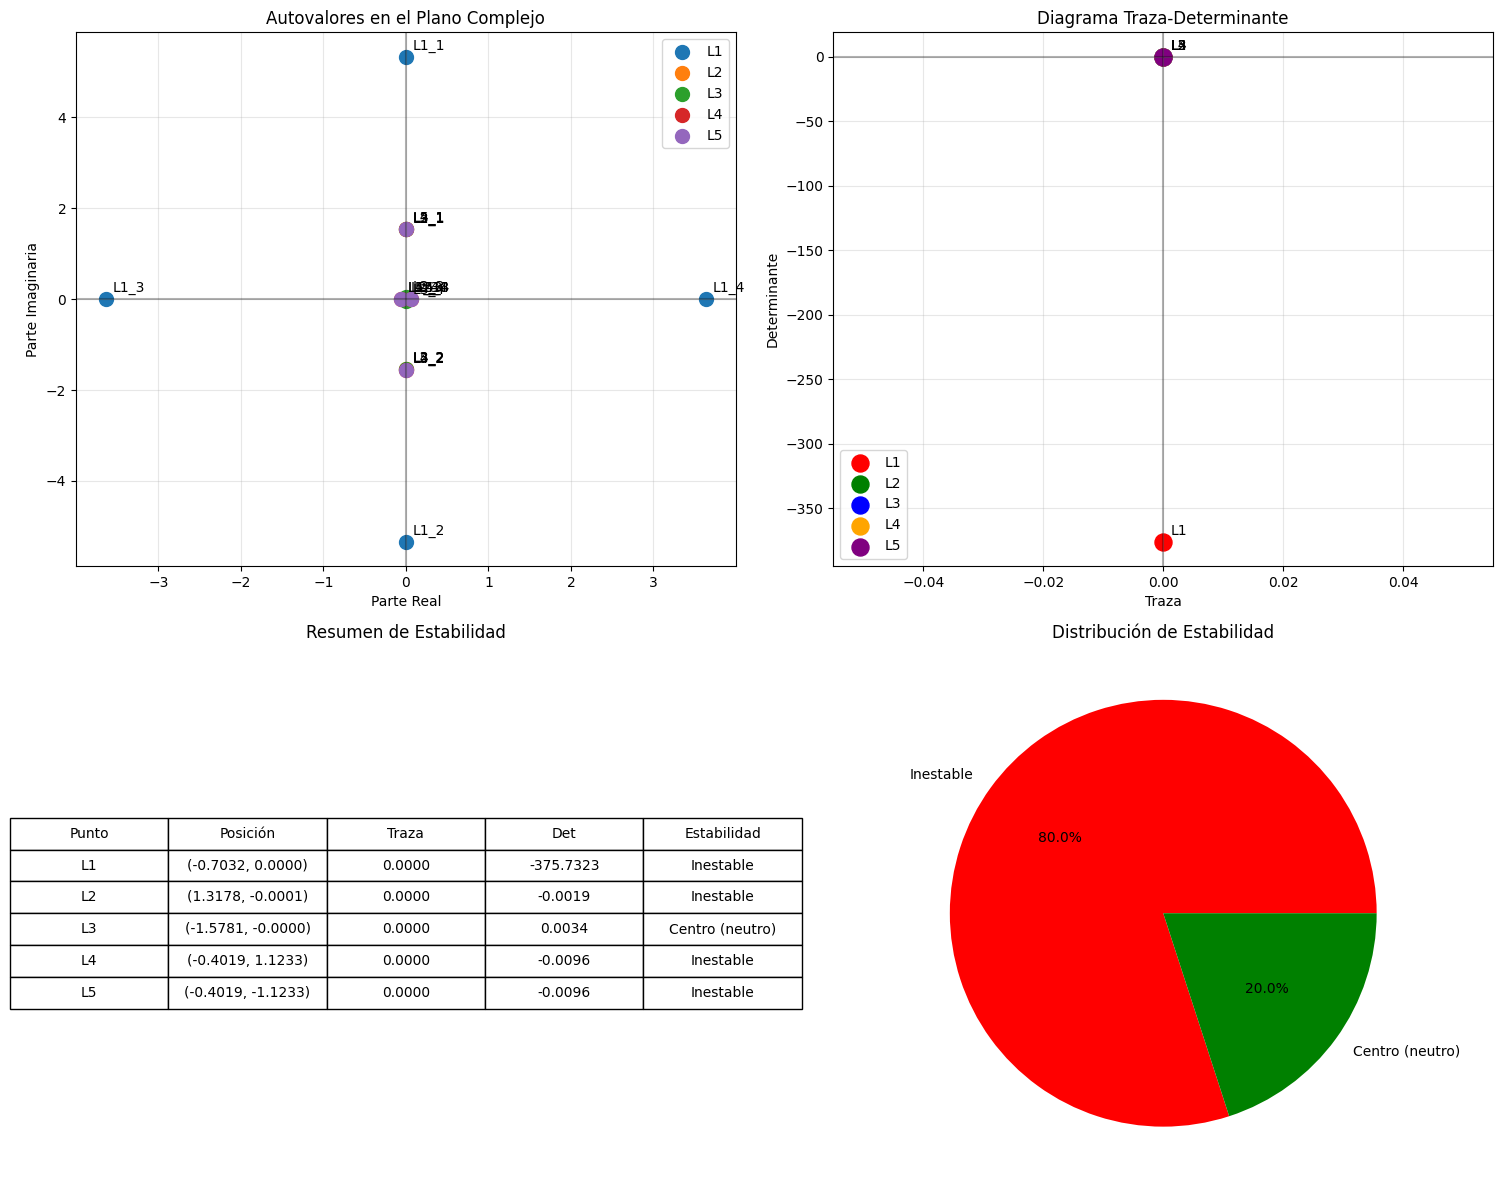


ANÁLISIS PARA q = 1.0
Puntos de Lagrange encontrados: ['L1', 'L2', 'L3', 'L4', 'L5']
ANÁLISIS DE ESTABILIDAD DE PUNTOS DE LAGRANGE (q = 1.0)

L1:
  Posición: (0.000000, 0.000000)
  Traza: 0.000000
  Determinante: -540.000000
  Estabilidad: Inestable
  Clasificación: Punto silla (inestable)
  Autovalores:
    λ1 = 0.000000+5.707575j
    λ2 = 0.000000-5.707575j
    λ3 = -4.071414+0.000000j
    λ4 = 4.071414+0.000000j

L2:
  Posición: (1.542531, -0.000000)
  Traza: 0.000000
  Determinante: 0.000661
  Estabilidad: Centro (neutro)
  Clasificación: Centro (neutro)
  Autovalores:
    λ1 = -0.000000+0.999614j
    λ2 = -0.000000-0.999614j
    λ3 = -0.000000+0.025711j
    λ4 = -0.000000-0.025711j

L3:
  Posición: (-1.542535, 0.001183)
  Traza: 0.000000
  Determinante: 0.000740
  Estabilidad: Centro (neutro)
  Clasificación: Centro (neutro)
  Autovalores:
    λ1 = 0.000000+0.999568j
    λ2 = 0.000000-0.999568j
    λ3 = -0.000000+0.027214j
    λ4 = -0.000000-0.027214j

L4:
  Posición: (0.000000, 

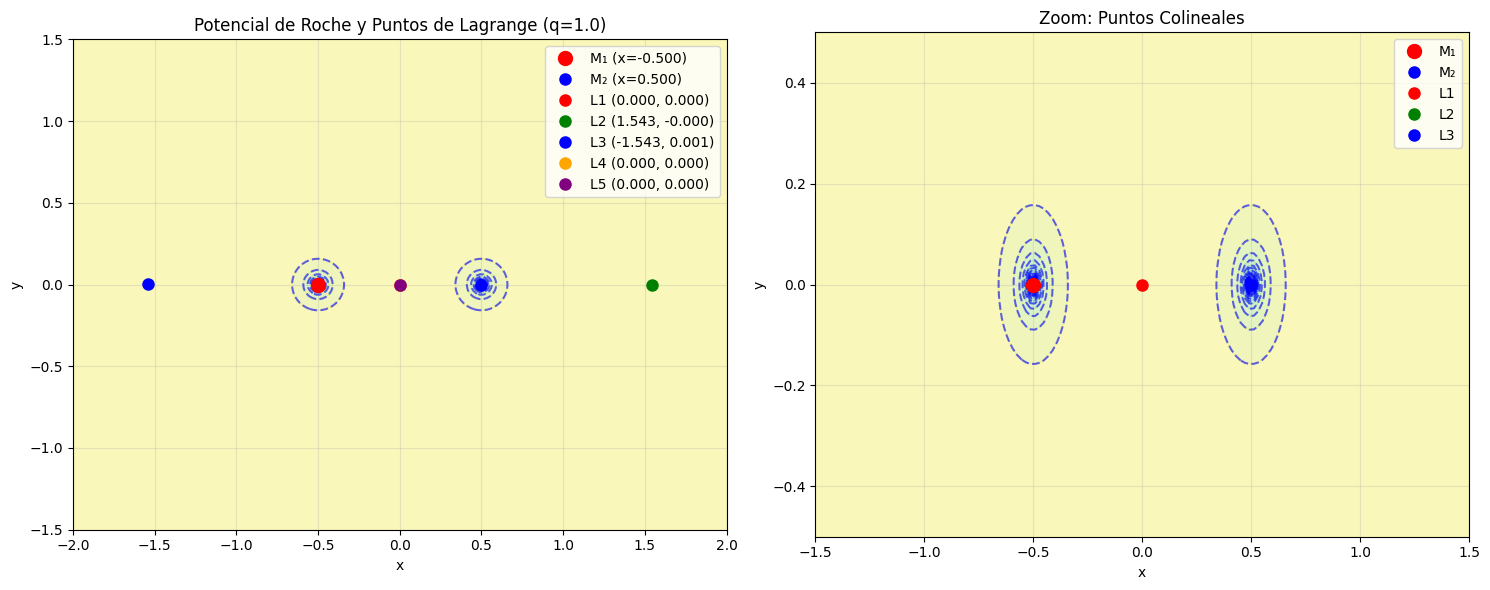

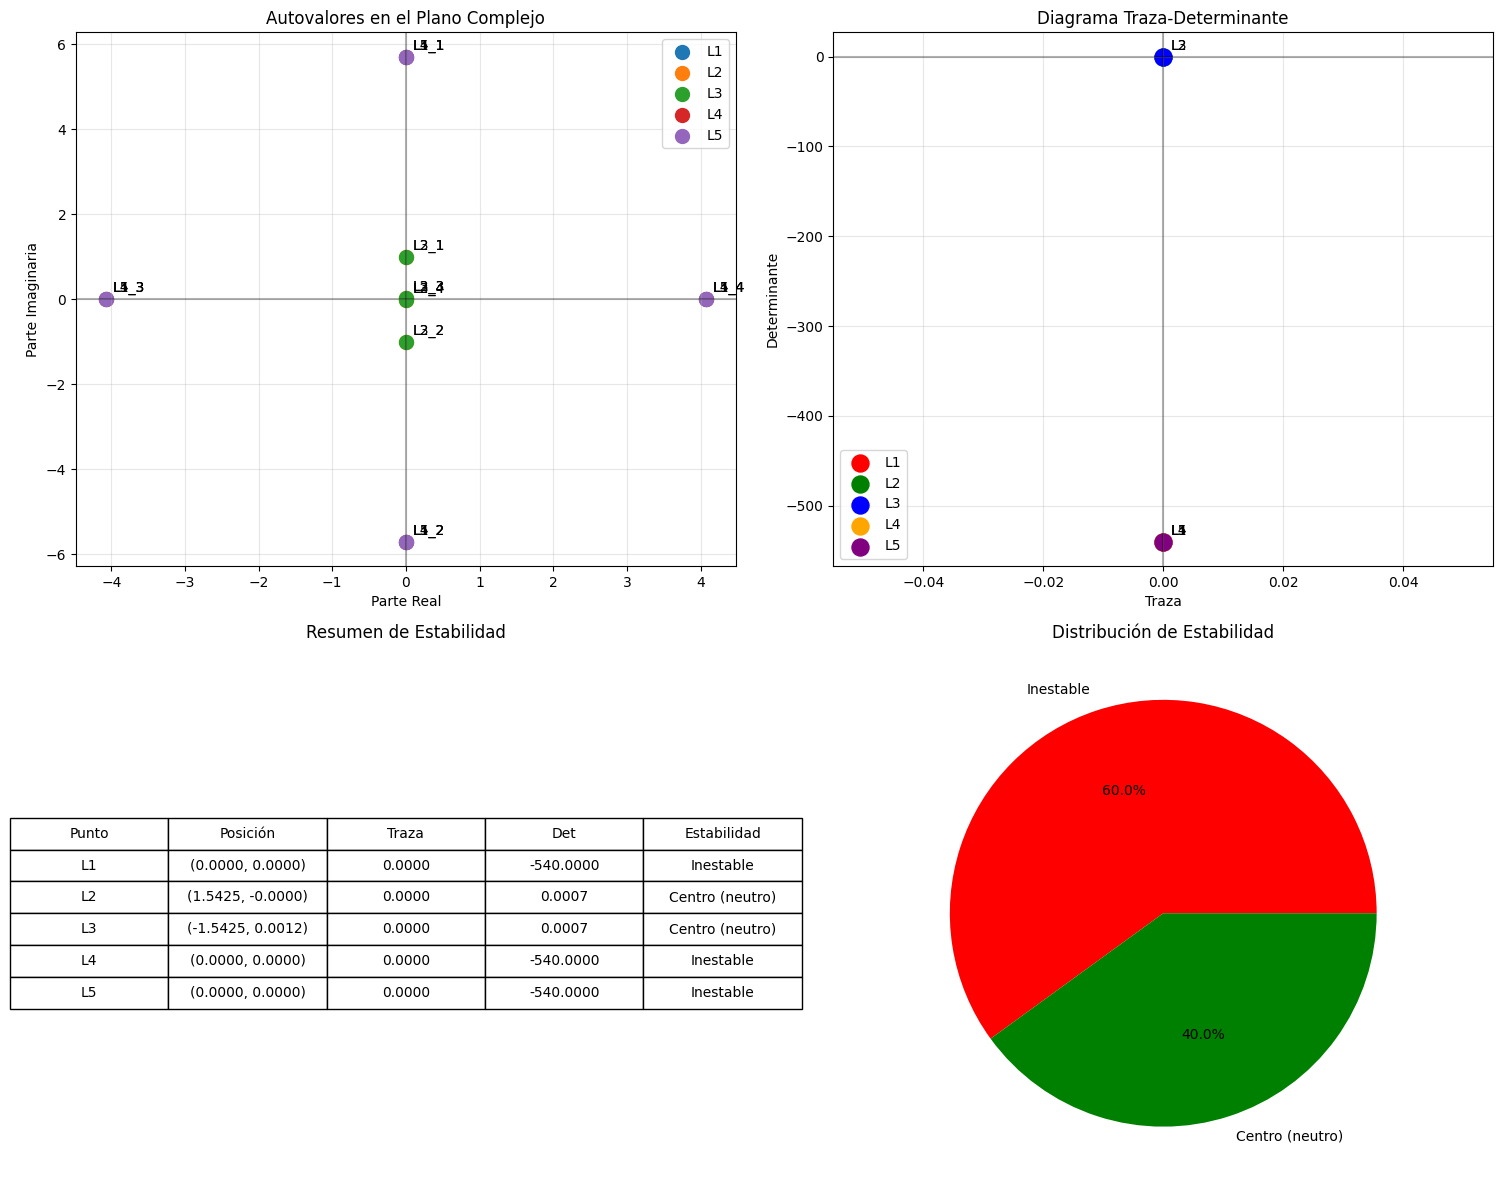

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import sympy as sp
from matplotlib.patches import Circle
import warnings
warnings.filterwarnings('ignore')

class LagrangeStabilityAnalysis:
    def __init__(self, q=1.0):
        """
        Análisis de estabilidad de puntos de Lagrange
        q: relación de masas M1/M2
        """
        self.q = q
        self.x1 = -1/(1 + q)  # Posición adimensional de M1
        self.x2 = q/(1 + q)   # Posición adimensional de M2
        
    def roche_potential(self, x, y):
        """Potencial de Roche adimensional"""
        r1 = np.sqrt((x - self.x1)**2 + y**2)
        r2 = np.sqrt((x - self.x2)**2 + y**2)
        return -(self.q/r1 + 1/r2 + 0.5*(1 + self.q)*(x**2 + y**2))
    
    def gradient_roche(self, x, y):
        """Gradiente del potencial de Roche"""
        r1 = np.sqrt((x - self.x1)**2 + y**2)
        r2 = np.sqrt((x - self.x2)**2 + y**2)
        
        # Derivadas parciales
        dPhi_dx = (self.q*(x - self.x1)/r1**3 + 
                   (x - self.x2)/r2**3 + 
                   (1 + self.q)*x)
        
        dPhi_dy = (self.q*y/r1**3 + 
                   y/r2**3 + 
                   (1 + self.q)*y)
        
        return np.array([dPhi_dx, dPhi_dy])
    
    def find_lagrange_points(self):
        """Encuentra los 5 puntos de Lagrange"""
        def equilibrium_condition(vars):
            x, y = vars
            grad = self.gradient_roche(x, y)
            return [grad[0], grad[1]]
        
        # Estimaciones iniciales para los puntos de Lagrange
        lagrange_points = {}
        
        # L1: entre las masas
        x0_L1 = 0.5 * (self.x1 + self.x2)
        try:
            L1 = fsolve(equilibrium_condition, [x0_L1, 0], xtol=1e-12)[0:2]
            lagrange_points['L1'] = L1
        except:
            print("No se pudo encontrar L1")
        
        # L2: fuera del sistema, lado de M2
        x0_L2 = self.x2 + 0.1
        try:
            L2 = fsolve(equilibrium_condition, [x0_L2, 0], xtol=1e-12)[0:2]
            lagrange_points['L2'] = L2
        except:
            print("No se pudo encontrar L2")
        
        # L3: fuera del sistema, lado de M1
        x0_L3 = self.x1 - 0.1
        try:
            L3 = fsolve(equilibrium_condition, [x0_L3, 0], xtol=1e-12)[0:2]
            lagrange_points['L3'] = L3
        except:
            print("No se pudo encontrar L3")
        
        # L4 y L5: triángulos equiláteros
        x_center = (self.x1 + self.x2) / 2
        y_L4 = np.sqrt(3) * abs(self.x2 - self.x1) / 2
        
        try:
            L4 = fsolve(equilibrium_condition, [x_center, y_L4], xtol=1e-12)[0:2]
            lagrange_points['L4'] = L4
        except:
            print("No se pudo encontrar L4")
        
        try:
            L5 = fsolve(equilibrium_condition, [x_center, -y_L4], xtol=1e-12)[0:2]
            lagrange_points['L5'] = L5
        except:
            print("No se pudo encontrar L5")
        
        return lagrange_points
    
    def hessian_roche(self, x, y):
        """Calcula la matriz Hessiana del potencial de Roche"""
        r1 = np.sqrt((x - self.x1)**2 + y**2)
        r2 = np.sqrt((x - self.x2)**2 + y**2)
        
        # Segundas derivadas
        d2Phi_dx2 = (self.q * (1/r1**3 - 3*(x - self.x1)**2/r1**5) + 
                     (1/r2**3 - 3*(x - self.x2)**2/r2**5) + 
                     (1 + self.q))
        
        d2Phi_dy2 = (self.q * (1/r1**3 - 3*y**2/r1**5) + 
                     (1/r2**3 - 3*y**2/r2**5) + 
                     (1 + self.q))
        
        d2Phi_dxdy = (-3*self.q*(x - self.x1)*y/r1**5 - 
                      3*(x - self.x2)*y/r2**5)
        
        return np.array([[d2Phi_dx2, d2Phi_dxdy],
                        [d2Phi_dxdy, d2Phi_dy2]])
    
    def jacobian_matrix(self, x, y):
        """Construye la matriz Jacobiana del sistema linealizado"""
        H = self.hessian_roche(x, y)
        
        # Matriz Jacobiana 4x4
        A = np.array([
            [0, 0, 1, 0],
            [0, 0, 0, 1],
            [H[0,0], H[0,1], 0, 2],
            [H[1,0], H[1,1], -2, 0]
        ])
        
        return A
    
    def analyze_stability(self, lagrange_points):
        """Analiza la estabilidad de cada punto de Lagrange"""
        stability_results = {}
        
        for name, point in lagrange_points.items():
            x, y = point
            
            # Calcula la matriz Jacobiana
            A = self.jacobian_matrix(x, y)
            
            # Calcula autovalores
            eigenvalues = np.linalg.eigvals(A)
            
            # Calcula traza y determinante
            trace = np.trace(A)
            det = np.linalg.det(A)
            
            # Clasifica la estabilidad
            real_parts = np.real(eigenvalues)
            max_real = np.max(real_parts)
            
            if max_real > 1e-10:
                stability = "Inestable"
            elif np.max(np.abs(real_parts)) < 1e-10:
                stability = "Centro (neutro)"
            else:
                stability = "Estable"
            
            # Clasificación adicional según traza y determinante
            if det < 0:
                classification = "Punto silla (inestable)"
            elif det > 0 and trace < 0:
                classification = "Nodo o espiral estable"
            elif det > 0 and trace > 0:
                classification = "Nodo o espiral inestable"
            elif abs(trace) < 1e-10:
                classification = "Centro (neutro)"
            else:
                classification = "Indeterminado"
            
            stability_results[name] = {
                'position': point,
                'eigenvalues': eigenvalues,
                'trace': trace,
                'determinant': det,
                'stability': stability,
                'classification': classification
            }
        
        return stability_results
    
    def plot_potential_and_points(self, lagrange_points):
        """Grafica el potencial de Roche y los puntos de Lagrange"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Malla para el potencial
        x = np.linspace(-2, 2, 200)
        y = np.linspace(-1.5, 1.5, 200)
        X, Y = np.meshgrid(x, y)
        
        # Calcula el potencial evitando singularidades
        Z = np.zeros_like(X)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                r1 = np.sqrt((X[i,j] - self.x1)**2 + Y[i,j]**2)
                r2 = np.sqrt((X[i,j] - self.x2)**2 + Y[i,j]**2)
                if r1 > 0.01 and r2 > 0.01:  # Evita singularidades
                    Z[i,j] = self.roche_potential(X[i,j], Y[i,j])
                else:
                    Z[i,j] = np.nan
        
        # Gráfico de contorno del potencial
        levels = np.linspace(np.nanmin(Z), np.nanmax(Z), 20)
        contour = ax1.contour(X, Y, Z, levels=levels, colors='blue', alpha=0.6)
        ax1.contourf(X, Y, Z, levels=levels, alpha=0.3, cmap='viridis')
        
        # Marca las masas
        ax1.plot(self.x1, 0, 'ro', markersize=10, label=f'M₁ (x={self.x1:.3f})')
        ax1.plot(self.x2, 0, 'bo', markersize=8, label=f'M₂ (x={self.x2:.3f})')
        
        # Marca los puntos de Lagrange
        colors = ['red', 'green', 'blue', 'orange', 'purple']
        for i, (name, point) in enumerate(lagrange_points.items()):
            ax1.plot(point[0], point[1], 'o', color=colors[i], 
                    markersize=8, label=f'{name} ({point[0]:.3f}, {point[1]:.3f})')
        
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_title(f'Potencial de Roche y Puntos de Lagrange (q={self.q})')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_aspect('equal')
        
        # Gráfico de zoom en los puntos colineales
        ax2.contour(X, Y, Z, levels=levels, colors='blue', alpha=0.6)
        ax2.contourf(X, Y, Z, levels=levels, alpha=0.3, cmap='viridis')
        
        # Marca las masas
        ax2.plot(self.x1, 0, 'ro', markersize=10, label=f'M₁')
        ax2.plot(self.x2, 0, 'bo', markersize=8, label=f'M₂')
        
        # Marca solo los puntos colineales
        for name, point in lagrange_points.items():
            if name in ['L1', 'L2', 'L3']:
                color = colors[['L1', 'L2', 'L3'].index(name)]
                ax2.plot(point[0], point[1], 'o', color=color, 
                        markersize=8, label=f'{name}')
        
        ax2.set_xlim(-1.5, 1.5)
        ax2.set_ylim(-0.5, 0.5)
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.set_title('Zoom: Puntos Colineales')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_stability_analysis(self, stability_results):
        """Grafica el análisis de estabilidad"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Gráfico 1: Autovalores en el plano complejo
        for name, result in stability_results.items():
            eigenvals = result['eigenvalues']
            real_parts = np.real(eigenvals)
            imag_parts = np.imag(eigenvals)
            
            ax1.scatter(real_parts, imag_parts, label=name, s=100)
            
            # Añade etiquetas a cada autovalor
            for i, (re, im) in enumerate(zip(real_parts, imag_parts)):
                ax1.annotate(f'{name}_{i+1}', (re, im), 
                           xytext=(5, 5), textcoords='offset points')
        
        ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        ax1.axvline(x=0, color='k', linestyle='-', alpha=0.3)
        ax1.set_xlabel('Parte Real')
        ax1.set_ylabel('Parte Imaginaria')
        ax1.set_title('Autovalores en el Plano Complejo')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Gráfico 2: Traza vs Determinante
        traces = [result['trace'] for result in stability_results.values()]
        dets = [result['determinant'] for result in stability_results.values()]
        names = list(stability_results.keys())
        
        colors = ['red', 'green', 'blue', 'orange', 'purple']
        for i, (name, trace, det) in enumerate(zip(names, traces, dets)):
            ax2.scatter(trace, det, color=colors[i], s=150, label=name)
            ax2.annotate(name, (trace, det), xytext=(5, 5), 
                        textcoords='offset points')
        
        ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        ax2.axvline(x=0, color='k', linestyle='-', alpha=0.3)
        ax2.set_xlabel('Traza')
        ax2.set_ylabel('Determinante')
        ax2.set_title('Diagrama Traza-Determinante')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Gráfico 3: Tabla de resultados
        ax3.axis('tight')
        ax3.axis('off')
        
        table_data = []
        for name, result in stability_results.items():
            table_data.append([
                name,
                f"({result['position'][0]:.4f}, {result['position'][1]:.4f})",
                f"{result['trace']:.4f}",
                f"{result['determinant']:.4f}",
                result['stability']
            ])
        
        table = ax3.table(cellText=table_data,
                         colLabels=['Punto', 'Posición', 'Traza', 'Det', 'Estabilidad'],
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.5)
        ax3.set_title('Resumen de Estabilidad')
        
        # Gráfico 4: Clasificación de estabilidad
        stabilities = [result['stability'] for result in stability_results.values()]
        unique_stabilities = list(set(stabilities))
        counts = [stabilities.count(s) for s in unique_stabilities]
        
        ax4.pie(counts, labels=unique_stabilities, autopct='%1.1f%%', 
                colors=colors[:len(unique_stabilities)])
        ax4.set_title('Distribución de Estabilidad')
        
        plt.tight_layout()
        plt.show()
    
    def print_detailed_results(self, stability_results):
        """Imprime resultados detallados"""
        print("="*80)
        print(f"ANÁLISIS DE ESTABILIDAD DE PUNTOS DE LAGRANGE (q = {self.q})")
        print("="*80)
        
        for name, result in stability_results.items():
            print(f"\n{name}:")
            print(f"  Posición: ({result['position'][0]:.6f}, {result['position'][1]:.6f})")
            print(f"  Traza: {result['trace']:.6f}")
            print(f"  Determinante: {result['determinant']:.6f}")
            print(f"  Estabilidad: {result['stability']}")
            print(f"  Clasificación: {result['classification']}")
            print("  Autovalores:")
            for i, ev in enumerate(result['eigenvalues']):
                print(f"    λ{i+1} = {ev:.6f}")
        
        print("\n" + "="*80)
        print("INTERPRETACIÓN FÍSICA:")
        print("="*80)
        
        # Resultados esperados según el documento
        expected_results = {
            'L1': 'Punto silla (inestable)',
            'L2': 'Punto silla (inestable)', 
            'L3': 'Punto silla (inestable)',
            'L4': f'Estable si q < 0.03852 (q = {self.q})',
            'L5': f'Estable si q < 0.03852 (q = {self.q})'
        }
        
        for name in ['L1', 'L2', 'L3', 'L4', 'L5']:
            if name in stability_results:
                result = stability_results[name]
                print(f"{name}: {result['classification']}")
                print(f"     Esperado: {expected_results[name]}")
                
                # Verificación especial para L4 y L5
                if name in ['L4', 'L5']:
                    if self.q < 0.03852:
                        print(f"     ✓ Condición q < 0.03852 satisfecha")
                    else:
                        print(f"     ✗ Condición q < 0.03852 NO satisfecha")

# Ejecutar el análisis
def main():
    # Diferentes valores de q para analizar
    q_values = [0.01, 0.05, 0.1, 1.0]
    
    for q in q_values:
        print(f"\n{'='*60}")
        print(f"ANÁLISIS PARA q = {q}")
        print(f"{'='*60}")
        
        # Crear instancia del análisis
        analyzer = LagrangeStabilityAnalysis(q=q)
        
        # Encontrar puntos de Lagrange
        lagrange_points = analyzer.find_lagrange_points()
        print(f"Puntos de Lagrange encontrados: {list(lagrange_points.keys())}")
        
        # Analizar estabilidad
        stability_results = analyzer.analyze_stability(lagrange_points)
        
        # Mostrar resultados detallados
        analyzer.print_detailed_results(stability_results)
        
        # Graficar resultados
        analyzer.plot_potential_and_points(lagrange_points)
        analyzer.plot_stability_analysis(stability_results)

if __name__ == "__main__":
    main()

## Análisis de Estabilidad de los Puntos de Lagrange en un Sistema Binario

Este código implementa una clase `LagrangeStabilityAnalysis` que estudia la **estabilidad dinámica** de los cinco puntos de Lagrange (L₁ a L₅) en un sistema binario rotante, usando el potencial de Roche y su análisis linealizado a través del cálculo de la matriz Jacobiana. El análisis está basado en las ecuaciones del movimiento de una partícula testigo en el marco co-rotante.

---

###  ¿Qué hace este código?

1. **Calcula los puntos de Lagrange** resolviendo el gradiente del potencial de Roche (\( \nabla \Phi = 0 \)) con `fsolve`.
2. **Calcula la matriz Hessiana** del potencial para cada punto encontrado.
3. **Construye la matriz Jacobiana 4x4** del sistema linealizado (Ecuación 14 del documento).
4. **Calcula autovalores, traza y determinante** para evaluar estabilidad.
5. **Clasifica** los puntos como:
   - Estables / inestables / centros (según parte real de autovalores),
   - Nodo / espiral / punto silla (según traza y determinante).
6. **Visualiza** el sistema binario con:
   - Contornos del potencial de Roche,
   - Ubicación de los puntos de Lagrange,
   - Autovalores en el plano complejo,
   - Diagrama traza-determinante,
   - Resumen tabular y torta de clasificación.
7. **Evalúa múltiples casos** con diferentes relaciones de masa \( q = M_1 / M_2 \) (por defecto: 0.01, 0.05, 0.1, 1.0).

---

###  Componentes principales del código

- **Clase `LagrangeStabilityAnalysis(q)`**:
  - `find_lagrange_points`: Encuentra los cinco puntos Lagrange resolviendo \( \nabla \Phi = 0 \).
  - `hessian_roche`: Calcula la matriz Hessiana \( H(x,y) \) del potencial.
  - `jacobian_matrix`: Construye la matriz Jacobiana completa 4x4.
  - `analyze_stability`: Calcula autovalores, traza y determinante. Clasifica la estabilidad.
  - `plot_potential_and_points`: Muestra el potencial y localización de los puntos.
  - `plot_stability_analysis`: Gráfica autovalores, traza/determinante, resumen tabular y gráfico de pastel.
  - `print_detailed_results`: Imprime todos los resultados con interpretación física y comparación con teoría.

- **Función `main()`**:
  - Ejecuta el análisis completo para diferentes valores de \( q \),
  - Evalúa los resultados esperados:
    - L₁, L₂, L₃ → puntos silla (inestables),
    - L₄, L₅ → estables solo si \( q < 0.03852 \).

---

###  Salidas esperadas

- Tabla con posiciones, traza, determinante, autovalores y clasificación.
- Verificación de condición teórica \( q < 0.03852 \) para L₄ y L₅.
- Visualizaciones para presentación o reporte científico.
- Interpretación física clara del comportamiento dinámico en torno a cada punto de equilibrio.

---

###  Aplicaciones

Este análisis es fundamental para:

- Modelar **transferencia de masa** entre estrellas binarias (por ejemplo, en L₁).
- Entender la estabilidad de objetos como troyanos en L₄ y L₅.
- Construir simulaciones orbitales de partículas testigo.
- Comparar con soluciones analíticas del problema restringido de tres cuerpos.

---
 comprender a fondo el comportamiento local de una partícula en un sistema binario rotante bajo el potencial de Roche.


### Análisis físico 

Este código realiza un análisis físico y matemático detallado de la **estabilidad dinámica** de los cinco puntos de Lagrange en un sistema binario rotante, caracterizado por el potencial de Roche adimensional. A diferencia del primer código, que solo identifica la ubicación de los puntos donde el gradiente del potencial es cero (\( \nabla \Phi = 0 \)), este además evalúa la **respuesta del sistema a perturbaciones pequeñas** alrededor de dichos puntos. Para ello, construye la **matriz Jacobiana** del sistema linealizado a partir de la matriz Hessiana del potencial y calcula sus **autovalores**, lo cual permite clasificar la estabilidad de cada punto (estable, inestable o centro neutro) según la teoría de sistemas dinámicos. El código compara los resultados numéricos con las predicciones teóricas, como por ejemplo que \( L_4 \) y \( L_5 \) solo son estables si la razón de masas \( q < 0.03852 \). También visualiza el potencial de Roche, los puntos de equilibrio y los resultados del análisis (como la traza y el determinante de la matriz Jacobiana) a través de gráficos interpretables. En conjunto, este código no solo identifica los puntos de equilibrio, sino que también estudia su **estabilidad estructural**, ofreciendo un diagnóstico completo sobre la dinámica local de una partícula testigo en un sistema binario.


## 4. Uso de la constante de Jacobi y zonas prohibidas

### Pregunta central

> **¿Cómo se puede caracterizar el movimiento permitido de una partícula testigo en función de su energía efectiva en el sistema binario?**

---

### Definición de la constante de Jacobi

La constante de Jacobi $C_J$ es una cantidad conservada en el marco rotante y se define como:

$$
C_J = 2\tilde{\Phi}_R(x, y) - \left(\dot{x}^2 + \dot{y}^2\right)
$$

Este valor combina el **potencial efectivo** con la **energía cinética** en el marco rotante.

---

### Curvas de velocidad cero (ZVC)

Las curvas donde la partícula se detendría (es decir, $\dot{x} = \dot{y} = 0$) satisfacen:

$$
C_J = 2\tilde{\Phi}_R(x, y)
$$

Estas curvas definen las **fronteras del espacio accesible** para una partícula con un valor fijo de $C_J$.

---

### Regiones prohibidas

Dado que $\dot{x}^2 + \dot{y}^2 \geq 0$, la partícula solo puede estar en regiones donde:

$$
2\tilde{\Phi}_R(x, y) \geq C_J
$$

Las regiones donde $2\tilde{\Phi}_R < C_J$ son **inalcanzables** para la partícula: no puede entrar, ni siquiera con velocidad.

---

### Interpretación física y dinámica

- Si $C_J > C_J(L_1)$: los **lóbulos de Roche** están cerrados, no hay comunicación entre ellos.
- Si $C_J = C_J(L_1)$: se forma un **cuello de paso** — posible transferencia de masa.
- Si $C_J < C_J(L_1)$: la partícula puede **cruzar entre lóbulos**.
- Si $C_J < C_J(L_2)$: la partícula puede **escapar del sistema**.

---

### Visualización

Al graficar las **curvas de nivel** de $\tilde{\Phi}_R(x, y)$ y sombrear las regiones donde $2\tilde{\Phi}_R < C_J$, se pueden visualizar claramente:

- Las **regiones permitidas** de movimiento.
- Las **zonas prohibidas**.
- El **efecto de variar** $C_J$.

---

### Objetivo de esta etapa

- Calcular el valor de $C_J$ en los puntos $L_i$.
- Visualizar **regiones prohibidas** para diferentes valores de $C_J$.
- Estudiar el comportamiento **topológico del potencial**.


=== ANÁLISIS DEL SISTEMA BINARIO DE ROCHE ===
=== ANÁLISIS DE REGÍMENES FÍSICOS ===
Sistema con q = M₁/M₂ = 1.0
Posición M₁: x₁ = -0.5000
Posición M₂: x₂ = 0.5000

C_J(L1) = -8.0000
C_J(L4) = -8.0000
C_J(L5) = -8.0000

=== INTERPRETACIÓN FÍSICA ===
• Si C_J > -8.0000 (C_J(L1)): Lóbulos cerrados, no hay comunicación
• Si C_J = -8.0000 (C_J(L1)): Se forma cuello de paso - transferencia de masa
• Si C_J < -8.0000 (C_J(L1)): La partícula puede cruzar entre lóbulos

=== ANÁLISIS DE REGÍMENES FÍSICOS ===
Sistema con q = M₁/M₂ = 0.3
Posición M₁: x₁ = -0.7692
Posición M₂: x₂ = 0.2308

C_J(L1) = -5.0585

=== INTERPRETACIÓN FÍSICA ===
• Si C_J > -5.0585 (C_J(L1)): Lóbulos cerrados, no hay comunicación
• Si C_J = -5.0585 (C_J(L1)): Se forma cuello de paso - transferencia de masa
• Si C_J < -5.0585 (C_J(L1)): La partícula puede cruzar entre lóbulos

Generando visualizaciones para q=1.0...
C_J(L1) = -8.0000 en (0.0000, 0.0000)
C_J(L4) = -8.0000 en (0.0000, 0.0000)
C_J(L5) = -8.0000 en (0.0000, 0.00

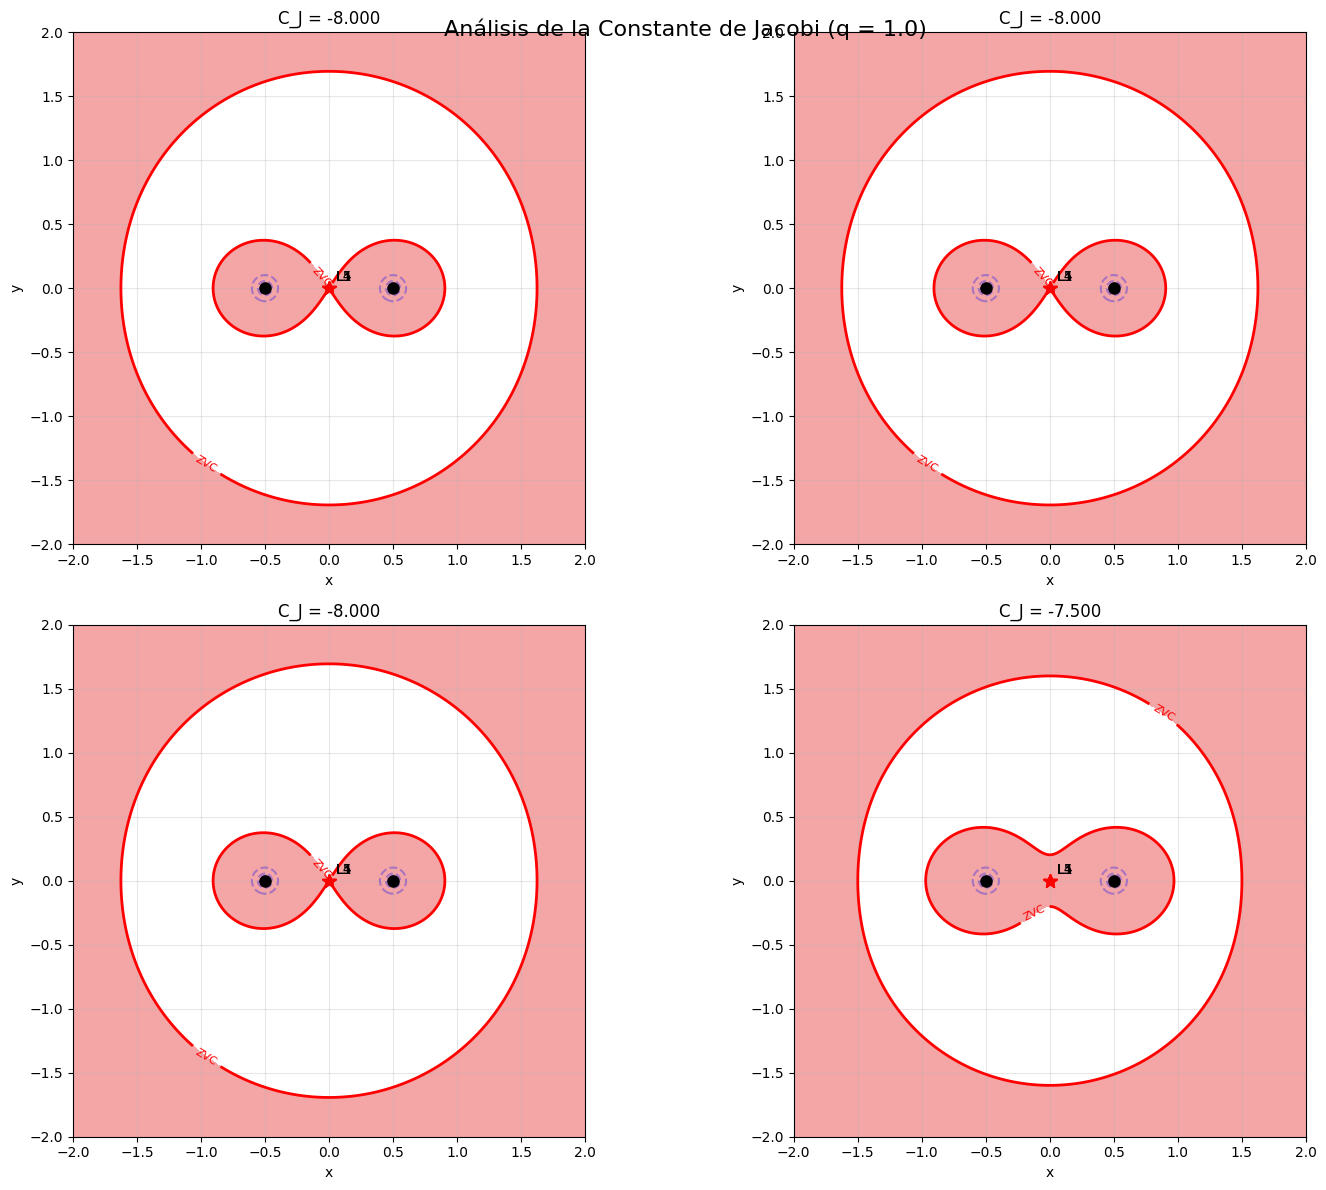


Potencial de Roche en 3D...


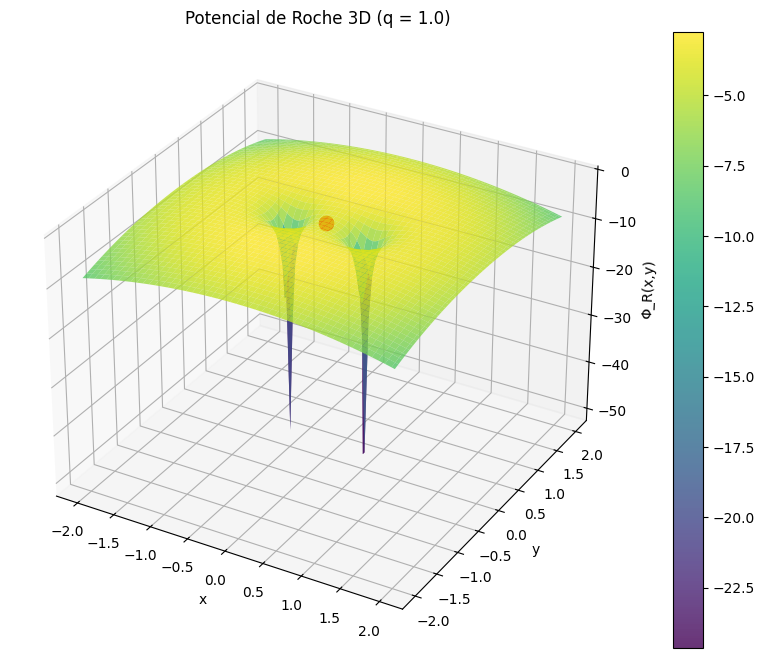


=== ANÁLISIS DETALLADO PARA VALORES ESPECÍFICOS ===

Análisis detallado para C_J cerca de L1:
C_J(L1) = -8.0000


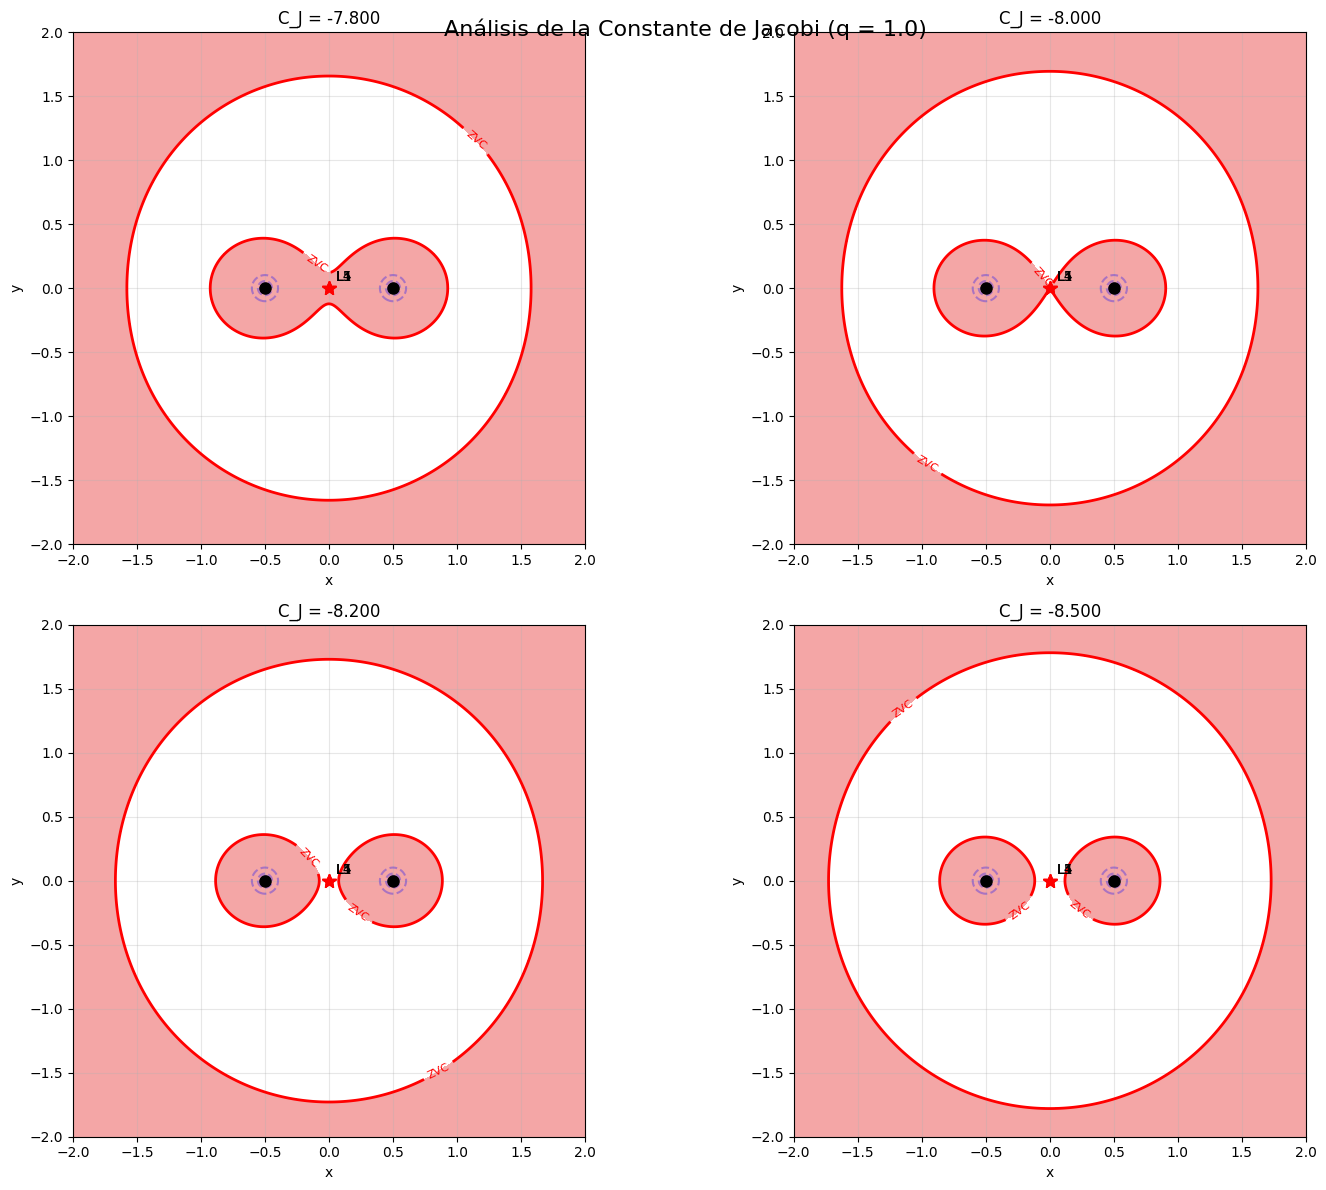

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from matplotlib.patches import Circle
import matplotlib.patches as patches

class RocheSystem:
    """
    Clase para el análisis del sistema binario de Roche con constante de Jacobi
    """
    
    def __init__(self, q=1.0):
        """
        Inicializa el sistema binario
        
        Parameters:
        q (float): Razón de masas M1/M2
        """
        self.q = q
        self.x1 = -1.0 / (1.0 + q)  # Posición adimensional de M1
        self.x2 = q / (1.0 + q)     # Posición adimensional de M2
        
    def roche_potential(self, x, y):
        """
        Calcula el potencial de Roche adimensional
        
        Parameters:
        x, y (float or array): Coordenadas adimensionales
        
        Returns:
        float or array: Valor del potencial de Roche
        """
        r1 = np.sqrt((x - self.x1)**2 + y**2)
        r2 = np.sqrt((x - self.x2)**2 + y**2)
        
        # Evitar división por cero
        r1 = np.where(r1 == 0, 1e-10, r1)
        r2 = np.where(r2 == 0, 1e-10, r2)
        
        phi_r = -self.q/r1 - 1.0/r2 - 0.5*(1 + self.q)*(x**2 + y**2)
        return phi_r
    
    def roche_potential_gradient(self, x, y):
        """
        Calcula el gradiente del potencial de Roche
        
        Parameters:
        x, y (float): Coordenadas adimensionales
        
        Returns:
        tuple: (dphi_dx, dphi_dy)
        """
        r1 = np.sqrt((x - self.x1)**2 + y**2)
        r2 = np.sqrt((x - self.x2)**2 + y**2)
        
        # Evitar división por cero
        r1 = max(r1, 1e-10)
        r2 = max(r2, 1e-10)
        
        dphi_dx = (self.q * (x - self.x1) / r1**3 + 
                   (x - self.x2) / r2**3 + 
                   (1 + self.q) * x)
        
        dphi_dy = (self.q * y / r1**3 + 
                   y / r2**3 + 
                   (1 + self.q) * y)
        
        return dphi_dx, dphi_dy
    
    def find_lagrange_points(self):
        """
        Encuentra los puntos de Lagrange del sistema
        
        Returns:
        dict: Diccionario con las coordenadas de los puntos L1-L5
        """
        def equilibrium_equations(vars):
            x, y = vars
            dphi_dx, dphi_dy = self.roche_potential_gradient(x, y)
            return [dphi_dx, dphi_dy]
        
        lagrange_points = {}
        
        # L1: entre las masas
        x_guess = (self.x1 + self.x2) / 2
        sol = fsolve(equilibrium_equations, [x_guess, 0])
        if abs(equilibrium_equations(sol)[0]) < 1e-10:
            lagrange_points['L1'] = sol
        
        # L2: fuera del sistema, dirección de M2
        x_guess = self.x2 + 0.1
        sol = fsolve(equilibrium_equations, [x_guess, 0])
        if abs(equilibrium_equations(sol)[0]) < 1e-10:
            lagrange_points['L2'] = sol
        
        # L3: fuera del sistema, dirección de M1
        x_guess = self.x1 - 0.1
        sol = fsolve(equilibrium_equations, [x_guess, 0])
        if abs(equilibrium_equations(sol)[0]) < 1e-10:
            lagrange_points['L3'] = sol
        
        # L4 y L5: triángulos equiláteros
        x_center = (self.x1 + self.x2) / 2
        y_offset = np.sqrt(3) / 2
        
        for i, y_guess in enumerate([y_offset, -y_offset], 4):
            sol = fsolve(equilibrium_equations, [x_center, y_guess])
            if abs(equilibrium_equations(sol)[1]) < 1e-10:
                lagrange_points[f'L{i}'] = sol
        
        return lagrange_points
    
    def jacobi_constant(self, x, y, vx, vy):
        """
        Calcula la constante de Jacobi
        
        Parameters:
        x, y (float): Posición
        vx, vy (float): Velocidad
        
        Returns:
        float: Valor de la constante de Jacobi
        """
        phi_r = self.roche_potential(x, y)
        kinetic_energy = 0.5 * (vx**2 + vy**2)
        return 2 * phi_r - 2 * kinetic_energy
    
    def zero_velocity_curves(self, C_J):
        """
        Calcula las curvas de velocidad cero para una constante de Jacobi dada
        
        Parameters:
        C_J (float): Valor de la constante de Jacobi
        
        Returns:
        tuple: Mallas de coordenadas y valores del potencial
        """
        x_range = np.linspace(-2, 2, 400)
        y_range = np.linspace(-2, 2, 400)
        X, Y = np.meshgrid(x_range, y_range)
        
        phi_r = self.roche_potential(X, Y)
        
        # Curva de velocidad cero: 2*phi_r = C_J
        zvc_condition = 2 * phi_r - C_J
        
        return X, Y, zvc_condition, phi_r
    
    def plot_jacobi_analysis(self, C_J_values=None, figsize=(15, 12)):
        """
        Visualiza el análisis completo de la constante de Jacobi
        
        Parameters:
        C_J_values (list): Lista de valores de C_J para analizar
        figsize (tuple): Tamaño de la figura
        """
        if C_J_values is None:
            # Encontrar puntos de Lagrange para determinar valores críticos
            lagrange_points = self.find_lagrange_points()
            C_J_values = []
            
            for point_name, coords in lagrange_points.items():
                if coords is not None:
                    x_l, y_l = coords
                    C_J_l = self.jacobi_constant(x_l, y_l, 0, 0)
                    C_J_values.append(C_J_l)
                    print(f"C_J({point_name}) = {C_J_l:.4f} en ({x_l:.4f}, {y_l:.4f})")
            
            # Agregar algunos valores adicionales para análisis
            if C_J_values:
                C_J_min = min(C_J_values)
                C_J_max = max(C_J_values)
                additional_values = [C_J_max + 0.5, C_J_min - 0.5]
                C_J_values.extend(additional_values)
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        axes = axes.flatten()
        
        # Encontrar puntos de Lagrange
        lagrange_points = self.find_lagrange_points()
        
        for i, C_J in enumerate(C_J_values[:4]):
            ax = axes[i]
            
            # Calcular curvas de velocidad cero
            X, Y, zvc_condition, phi_r = self.zero_velocity_curves(C_J)
            
            # Regiones prohibidas (donde 2*phi_r < C_J)
            forbidden_regions = zvc_condition < 0
            
            # Graficar regiones prohibidas
            ax.contourf(X, Y, forbidden_regions, levels=[0.5, 1.5], 
                       colors=['lightcoral'], alpha=0.7, 
                       label='Regiones prohibidas')
            
            # Graficar curvas de velocidad cero
            cs = ax.contour(X, Y, zvc_condition, levels=[0], 
                           colors=['red'], linewidths=2)
            ax.clabel(cs, inline=True, fontsize=8, fmt='ZVC')
            
            # Graficar equipotenciales
            levels = np.linspace(phi_r.min(), phi_r.max(), 20)
            ax.contour(X, Y, phi_r, levels=levels, alpha=0.3, colors='blue')
            
            # Marcar las masas
            ax.plot(self.x1, 0, 'ko', markersize=8, label=f'M₁ (q={self.q})')
            ax.plot(self.x2, 0, 'ko', markersize=8, label='M₂')
            
            # Marcar puntos de Lagrange
            for point_name, coords in lagrange_points.items():
                if coords is not None:
                    ax.plot(coords[0], coords[1], 'r*', markersize=10)
                    ax.annotate(point_name, (coords[0], coords[1]), 
                               xytext=(5, 5), textcoords='offset points')
            
            ax.set_xlim(-2, 2)
            ax.set_ylim(-2, 2)
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_title(f'C_J = {C_J:.3f}')
            ax.grid(True, alpha=0.3)
            ax.set_aspect('equal')
        
        plt.tight_layout()
        plt.suptitle(f'Análisis de la Constante de Jacobi (q = {self.q})', 
                    fontsize=16, y=0.98)
        plt.show()
    
    def analyze_physical_regimes(self):
        """
        Analiza los diferentes regímenes físicos según los valores de C_J
        """
        lagrange_points = self.find_lagrange_points()
        
        print("=== ANÁLISIS DE REGÍMENES FÍSICOS ===")
        print(f"Sistema con q = M₁/M₂ = {self.q}")
        print(f"Posición M₁: x₁ = {self.x1:.4f}")
        print(f"Posición M₂: x₂ = {self.x2:.4f}")
        print()
        
        # Calcular C_J en puntos de Lagrange
        C_J_values = {}
        for point_name, coords in lagrange_points.items():
            if coords is not None:
                x_l, y_l = coords
                C_J_l = self.jacobi_constant(x_l, y_l, 0, 0)
                C_J_values[point_name] = C_J_l
                print(f"C_J({point_name}) = {C_J_l:.4f}")
        
        print("\n=== INTERPRETACIÓN FÍSICA ===")
        
        if 'L1' in C_J_values:
            C_J_L1 = C_J_values['L1']
            print(f"• Si C_J > {C_J_L1:.4f} (C_J(L1)): Lóbulos cerrados, no hay comunicación")
            print(f"• Si C_J = {C_J_L1:.4f} (C_J(L1)): Se forma cuello de paso - transferencia de masa")
            print(f"• Si C_J < {C_J_L1:.4f} (C_J(L1)): La partícula puede cruzar entre lóbulos")
        
        if 'L2' in C_J_values:
            C_J_L2 = C_J_values['L2']
            print(f"• Si C_J < {C_J_L2:.4f} (C_J(L2)): La partícula puede escapar del sistema")
    
    def plot_potential_3d(self, figsize=(12, 8)):
        """
        Visualiza el potencial de Roche en 3D
        """
        x_range = np.linspace(-2, 2, 100)
        y_range = np.linspace(-2, 2, 100)
        X, Y = np.meshgrid(x_range, y_range)
        
        phi_r = self.roche_potential(X, Y)
        
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
        
        # Superficie del potencial
        surf = ax.plot_surface(X, Y, phi_r, cmap='viridis', alpha=0.8)
        
        # Puntos de Lagrange
        lagrange_points = self.find_lagrange_points()
        for point_name, coords in lagrange_points.items():
            if coords is not None:
                x_l, y_l = coords
                phi_l = self.roche_potential(x_l, y_l)
                ax.scatter(x_l, y_l, phi_l, color='red', s=100, label=point_name)
        
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('Φ_R(x,y)')
        ax.set_title(f'Potencial de Roche 3D (q = {self.q})')
        
        plt.colorbar(surf)
        plt.show()

# Ejemplo de uso
if __name__ == "__main__":
    # Crear sistema con diferentes razones de masa
    print("=== ANÁLISIS DEL SISTEMA BINARIO DE ROCHE ===")
    
    # Sistema con masas iguales
    system1 = RocheSystem(q=1.0)
    system1.analyze_physical_regimes()
    
    print("\n" + "="*60)
    
    # Sistema con masa dominante
    system2 = RocheSystem(q=0.3)
    system2.analyze_physical_regimes()
    
    # Visualización para q=1.0
    print("\nGenerando visualizaciones para q=1.0...")
    system1.plot_jacobi_analysis()
    
    # Visualización 3D del potencial
    print("\nPotencial de Roche en 3D...")
    system1.plot_potential_3d()
    
    # Análisis detallado de un valor específico de C_J
    print("\n=== ANÁLISIS DETALLADO PARA VALORES ESPECÍFICOS ===")
    lagrange_points = system1.find_lagrange_points()
    
    if 'L1' in lagrange_points:
        x_l1, y_l1 = lagrange_points['L1']
        C_J_L1 = system1.jacobi_constant(x_l1, y_l1, 0, 0)
        
        print(f"\nAnálisis detallado para C_J cerca de L1:")
        print(f"C_J(L1) = {C_J_L1:.4f}")
        
        # Visualizar diferentes casos
        test_values = [C_J_L1 + 0.2, C_J_L1, C_J_L1 - 0.2, C_J_L1 - 0.5]
        system1.plot_jacobi_analysis(C_J_values=test_values)

### Análisis físico 

Este código modela un sistema binario compuesto por dos masas \( M_1 \) y \( M_2 \) orbitando mutuamente, y analiza el comportamiento dinámico de una partícula testigo bajo la influencia del **potencial de Roche** en el marco de referencia rotante. La clase `RocheSystem` permite calcular dicho potencial, hallar los **cinco puntos de Lagrange** (equilibrios del sistema), y evaluar la **constante de Jacobi** \( C_J \), que es una cantidad conservada relacionada con la energía total en este marco.

Uno de los focos principales del código es el análisis de las **curvas de velocidad cero (ZVCs)**, que determinan las regiones del espacio donde una partícula **no puede acceder** para un valor dado de \( C_J \). Estas curvas delimitan zonas **prohibidas** y **permitidas**, lo que permite inferir diferentes regímenes físicos del sistema, como:
- **Lóbulos cerrados** (cuando \( C_J > C_J(L1) \)), donde las partículas están confinadas alrededor de cada estrella.
- **Formación de un cuello de paso** (cuando \( C_J = C_J(L1) \)), lo cual permite **transferencia de masa** entre componentes.
- **Escape del sistema** (cuando \( C_J < C_J(L2) \)), donde la partícula puede escapar hacia el infinito.

El código también incluye herramientas de visualización que muestran:
- El **potencial de Roche** en 2D y 3D.
- Las **ZVCs** sobre el plano \( x \)-\( y \).
- Las **regiones prohibidas**, según distintos valores de \( C_J \).
- La posición de las masas y puntos de Lagrange.

En resumen, este código no solo resuelve numéricamente la localización de los puntos de equilibrio, sino que proporciona una interpretación visual y física del sistema binario a través del análisis energético (Jacobi), haciendo énfasis en la dinámica orbital, la posibilidad de transferencia de masa y las condiciones para el escape gravitacional. Es ideal para estudiar la evolución de sistemas binarios como **estrellas dobles**, **exoplanetas en sistemas múltiples** o **acreción en binarias compactas**.


## 5. Masas variables y transferencia de masa

### Pregunta central

> **¿Qué ocurre cuando una de las masas del sistema binario gana o pierde masa en el tiempo? ¿Cómo afecta esto al potencial y a la dinámica del sistema?**

---

### Modelo con masas dependientes del tiempo

Ahora consideramos que las masas $M_1 = M_1(t)$ y $M_2 = M_2(t)$ pueden variar lentamente en el tiempo. Esta transferencia de masa puede deberse a procesos astrofísicos como **acreción**, **eyección** o **vientos estelares**.

La posición del centro de masas y las posiciones relativas también se ven afectadas por el cambio de $q(t) = M_1(t)/M_2(t)$.

---

### Evolución de la frecuencia orbital

La frecuencia orbital se ajusta con la relación de Kepler modificada:

$$
\Omega(t)^2 = \frac{G(M_1(t) + M_2(t))}{a(t)^3}
$$

Si asumimos que $a$ se mantiene constante por un tiempo, se puede usar una $\Omega(t)$ **variable**.

---

### Potencial de Roche con masas variables

El potencial efectivo ahora se convierte en una función de $t$:

$$
\tilde{\Phi}_R(x, y, t) = -\frac{q(t)}{\sqrt{(x - \tilde{x}_1(t))^2 + y^2}} - \frac{1}{\sqrt{(x - \tilde{x}_2(t))^2 + y^2}} - \frac{1}{2}(1 + q(t))(x^2 + y^2)
$$

Donde:

$$
\begin{align}
\tilde{x}_1(t) &= -\frac{1}{1 + q(t)} \\
\tilde{x}_2(t) &= \frac{q(t)}{1 + q(t)}
\end{align}
$$

---

### Efectos dinámicos de la transferencia de masa

- El punto $L_1$ se **desplaza**, modificando el cuello entre lóbulos.
- Cambia el **valor crítico** de $C_J$ asociado a los puntos de Lagrange.
- Se puede inducir una **transferencia de masa natural** de $M_1 \rightarrow M_2$ si $L_1$ cruza la superficie estelar.

---

### Estrategia de modelado

- Asignar una función $q(t)$ de evolución suave (por ejemplo, **decreciente exponencial** o **lineal**).
- Recalcular las posiciones de las masas y el potencial en cada instante.
- Integrar numéricamente las ecuaciones de movimiento.
- Analizar la evolución temporal de **regiones prohibidas**.

---

### Objetivo de esta etapa

- Modelar numéricamente la evolución de $q(t)$.
- Estudiar el **desplazamiento de los puntos $L_i$**.
- Visualizar cómo cambia la **estructura del potencial** y las **zonas permitidas**.


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve
import matplotlib.animation as animation
from matplotlib.patches import Circle

class RocheVariableMasses:
    def __init__(self, q_function, time_span):
        """
        Inicializa el modelo de Roche con masas variables
        
        Parameters:
        q_function: función que describe la evolución de q(t) = M1(t)/M2(t)
        time_span: tupla (t_inicio, t_final) para la evolución temporal
        """
        self.q_function = q_function
        self.time_span = time_span
        
    def q_evolution(self, t):
        """Calcula q(t) usando la función proporcionada"""
        return self.q_function(t)
    
    def stellar_positions(self, t):
        """Calcula las posiciones adimensionales de las masas en tiempo t"""
        q_t = self.q_evolution(t)
        x1_t = -1.0 / (1.0 + q_t)
        x2_t = q_t / (1.0 + q_t)
        return x1_t, x2_t
    
    def roche_potential(self, x, y, t):
        """Calcula el potencial de Roche adimensional en tiempo t"""
        q_t = self.q_evolution(t)
        x1_t, x2_t = self.stellar_positions(t)
        
        r1 = np.sqrt((x - x1_t)**2 + y**2)
        r2 = np.sqrt((x - x2_t)**2 + y**2)
        
        # Evitar división por cero
        r1 = np.where(r1 < 1e-10, 1e-10, r1)
        r2 = np.where(r2 < 1e-10, 1e-10, r2)
        
        phi_R = -q_t/r1 - 1.0/r2 - 0.5*(1 + q_t)*(x**2 + y**2)
        return phi_R
    
    def roche_derivatives(self, x, y, t):
        """Calcula las derivadas del potencial de Roche"""
        q_t = self.q_evolution(t)
        x1_t, x2_t = self.stellar_positions(t)
        
        r1 = np.sqrt((x - x1_t)**2 + y**2)
        r2 = np.sqrt((x - x2_t)**2 + y**2)
        
        # Evitar división por cero
        r1 = np.where(r1 < 1e-10, 1e-10, r1)
        r2 = np.where(r2 < 1e-10, 1e-10, r2)
        
        dphi_dx = q_t*(x - x1_t)/r1**3 + (x - x2_t)/r2**3 + (1 + q_t)*x
        dphi_dy = q_t*y/r1**3 + y/r2**3 + (1 + q_t)*y
        
        return dphi_dx, dphi_dy
    
    def equations_of_motion(self, state, t):
        """Ecuaciones de movimiento de la partícula testigo"""
        x, y, vx, vy = state
        
        dphi_dx, dphi_dy = self.roche_derivatives(x, y, t)
        
        # Ecuaciones de movimiento con términos de Coriolis
        dxdt = vx
        dydt = vy
        dvxdt = -dphi_dx + 2*vy
        dvydt = -dphi_dy - 2*vx
        
        return [dxdt, dydt, dvxdt, dvydt]
    
    def find_lagrange_points(self, t):
        """Encuentra los puntos de Lagrange en tiempo t"""
        q_t = self.q_evolution(t)
        x1_t, x2_t = self.stellar_positions(t)
        
        def lagrange_conditions(vars):
            x, y = vars
            dphi_dx, dphi_dy = self.roche_derivatives(x, y, t)
            return [dphi_dx, dphi_dy]
        
        # Estimaciones iniciales para los puntos de Lagrange
        L1_guess = [0.5*(x1_t + x2_t), 0]
        L2_guess = [x2_t + 0.3, 0]
        L3_guess = [x1_t - 0.3, 0]
        L4_guess = [0.5*(x1_t + x2_t), 0.866]
        L5_guess = [0.5*(x1_t + x2_t), -0.866]
        
        lagrange_points = {}
        guesses = [L1_guess, L2_guess, L3_guess, L4_guess, L5_guess]
        names = ['L1', 'L2', 'L3', 'L4', 'L5']
        
        for i, guess in enumerate(guesses):
            try:
                sol = fsolve(lagrange_conditions, guess, xtol=1e-12)
                # Verificar que es realmente una solución
                residual = np.linalg.norm(lagrange_conditions(sol))
                if residual < 1e-10:
                    lagrange_points[names[i]] = sol
            except:
                pass
        
        return lagrange_points
    
    def jacobi_constant(self, x, y, vx, vy, t):
        """Calcula la constante de Jacobi"""
        phi_R = self.roche_potential(x, y, t)
        CJ = 2*phi_R - (vx**2 + vy**2)
        return CJ
    
    def plot_potential_evolution(self, times, xlim=(-2, 2), ylim=(-2, 2)):
        """Visualiza la evolución del potencial de Roche"""
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.flatten()
        
        x = np.linspace(xlim[0], xlim[1], 100)
        y = np.linspace(ylim[0], ylim[1], 100)
        X, Y = np.meshgrid(x, y)
        
        for i, t in enumerate(times):
            if i >= 4:
                break
                
            ax = axes[i]
            q_t = self.q_evolution(t)
            x1_t, x2_t = self.stellar_positions(t)
            
            Z = self.roche_potential(X, Y, t)
            
            # Contornos del potencial
            contours = ax.contour(X, Y, Z, levels=20, colors='blue', alpha=0.6)
            ax.clabel(contours, inline=True, fontsize=8)
            
            # Posiciones de las masas
            ax.plot(x1_t, 0, 'ro', markersize=8*q_t, label=f'M1 (q={q_t:.3f})')
            ax.plot(x2_t, 0, 'bo', markersize=8, label='M2')
            
            # Puntos de Lagrange
            lagrange_points = self.find_lagrange_points(t)
            for name, point in lagrange_points.items():
                ax.plot(point[0], point[1], 'g*', markersize=10, alpha=0.7)
                ax.text(point[0], point[1]+0.1, name, ha='center', fontsize=8)
            
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.set_aspect('equal')
            ax.set_title(f't = {t:.2f}, q = {q_t:.3f}')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_lagrange_evolution(self, t_array):
        """Visualiza la evolución de los puntos de Lagrange"""
        L1_positions = []
        L2_positions = []
        L3_positions = []
        q_values = []
        
        for t in t_array:
            lagrange_points = self.find_lagrange_points(t)
            q_values.append(self.q_evolution(t))
            
            if 'L1' in lagrange_points:
                L1_positions.append(lagrange_points['L1'])
            if 'L2' in lagrange_points:
                L2_positions.append(lagrange_points['L2'])
            if 'L3' in lagrange_points:
                L3_positions.append(lagrange_points['L3'])
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Evolución temporal de las posiciones
        if L1_positions:
            L1_x = [pos[0] for pos in L1_positions]
            ax1.plot(t_array[:len(L1_x)], L1_x, 'r-', label='L1', linewidth=2)
        if L2_positions:
            L2_x = [pos[0] for pos in L2_positions]
            ax1.plot(t_array[:len(L2_x)], L2_x, 'b-', label='L2', linewidth=2)
        if L3_positions:
            L3_x = [pos[0] for pos in L3_positions]
            ax1.plot(t_array[:len(L3_x)], L3_x, 'g-', label='L3', linewidth=2)
        
        ax1.set_xlabel('Tiempo')
        ax1.set_ylabel('Posición x')
        ax1.set_title('Evolución temporal de los puntos de Lagrange')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Evolución de q(t)
        ax2.plot(t_array, q_values, 'k-', linewidth=2)
        ax2.set_xlabel('Tiempo')
        ax2.set_ylabel('q(t) = M1/M2')
        ax2.set_title('Evolución de la razón de masas')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def simulate_particle_trajectory(self, initial_conditions, t_span, dt=0.01):
        """Simula la trayectoria de una partícula testigo"""
        t_array = np.arange(t_span[0], t_span[1], dt)
        
        # Integrar las ecuaciones de movimiento
        trajectory = odeint(self.equations_of_motion, initial_conditions, t_array)
        
        return t_array, trajectory
    
    def plot_trajectory_evolution(self, initial_conditions, t_span, dt=0.01):
        """Visualiza la trayectoria de la partícula con potencial variable"""
        t_array, trajectory = self.simulate_particle_trajectory(initial_conditions, t_span, dt)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Trayectoria en el plano xy
        x_traj = trajectory[:, 0]
        y_traj = trajectory[:, 1]
        
        ax1.plot(x_traj, y_traj, 'b-', linewidth=1, alpha=0.7, label='Trayectoria')
        ax1.plot(x_traj[0], y_traj[0], 'go', markersize=8, label='Inicio')
        ax1.plot(x_traj[-1], y_traj[-1], 'ro', markersize=8, label='Final')
        
        # Agregar posiciones de las masas en diferentes tiempos
        for i, t in enumerate(t_array[::len(t_array)//5]):
            x1_t, x2_t = self.stellar_positions(t)
            alpha = 0.3 + 0.7*i/(len(t_array)//5)
            ax1.plot(x1_t, 0, 'ro', markersize=6, alpha=alpha)
            ax1.plot(x2_t, 0, 'bo', markersize=6, alpha=alpha)
        
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_title('Trayectoria de la partícula testigo')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_aspect('equal')
        
        # Constante de Jacobi vs tiempo
        CJ_values = []
        for i, t in enumerate(t_array):
            x, y, vx, vy = trajectory[i]
            CJ = self.jacobi_constant(x, y, vx, vy, t)
            CJ_values.append(CJ)
        
        ax2.plot(t_array, CJ_values, 'r-', linewidth=2)
        ax2.set_xlabel('Tiempo')
        ax2.set_ylabel('Constante de Jacobi')
        ax2.set_title('Evolución de la constante de Jacobi')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return t_array, trajectory


# Ejemplos de uso y funciones de evolución de q(t)

def exponential_decay(t, q0=1.0, tau=2.0):
    """Decaimiento exponencial: q(t) = q0 * exp(-t/tau)"""
    return q0 * np.exp(-t/tau)

def linear_decrease(t, q0=1.0, rate=0.1):
    """Decrecimiento lineal: q(t) = q0 - rate*t"""
    return np.maximum(0.1, q0 - rate*t)

def sinusoidal_variation(t, q0=1.0, amplitude=0.3, period=5.0):
    """Variación sinusoidal: q(t) = q0 + amplitude*sin(2π*t/period)"""
    return q0 + amplitude * np.sin(2*np.pi*t/period)

# Ejemplo de uso
if __name__ == "__main__":
    # Definir la función de evolución de q(t)
    q_func = lambda t: exponential_decay(t, q0=1.0, tau=3.0)
    
    # Crear el modelo
    model = RocheVariableMasses(q_func, (0, 10))
    
    # Visualizar la evolución del potencial
    times = [0, 2, 4, 6]
    model.plot_potential_evolution(times)
    
    # Evolución de los puntos de Lagrange
    t_array = np.linspace(0, 10, 50)
    model.plot_lagrange_evolution(t_array)
    
    # Simular trayectoria de partícula
    initial_conditions = [0.5, 0.2, 0.1, 0.0]  # [x0, y0, vx0, vy0]
    t_span = (0, 8)
    model.plot_trajectory_evolution(initial_conditions, t_span)
    
    print("Simulación completada. Se han generado gráficos mostrando:")
    print("1. Evolución del potencial de Roche")
    print("2. Movimiento de los puntos de Lagrange")
    print("3. Trayectoria de partícula testigo")
    print("4. Evolución de la constante de Jacobi")

Simulación completada. Se han generado gráficos mostrando:
1. Evolución del potencial de Roche
2. Movimiento de los puntos de Lagrange
3. Trayectoria de partícula testigo
4. Evolución de la constante de Jacobi



Descripción del Código

Este código modela un sistema binario de Roche donde la razón de masas `q = M₁/M₂` varía con el tiempo, permitiendo estudiar sistemas binarios con transferencia de masa o evolución estelar.

Componentes principales

1. **Clase `RocheVariableMasses`**:
   - Modela un sistema binario con razón de masas `q(t)` variable
   - Calcula el potencial de Roche dependiente del tiempo
   - Simula trayectorias de partículas testigo
   - Rastrea la evolución de los puntos de Lagrange

2. **Métodos clave**:
   - `roche_potential()`: Potencial efectivo dependiente del tiempo
   - `find_lagrange_points()`: Localiza puntos de equilibrio dinámicos
   - `equations_of_motion()`: Incluye términos de Coriolis y potencial variable
   - `simulate_particle_trajectory()`: Resuelve las ecuaciones de movimiento
   - Funciones de visualización para evolución temporal

3. **Funciones de evolución de q(t)**:
   - Decaimiento exponencial
   - Decrecimiento lineal
   - Variación sinusoidal



## Analisis Físico 
Este código modela la dinámica de una partícula testigo en un sistema binario donde la razón de masas \(q(t) = M_1(t)/M_2(t)\) varía con el tiempo, representando físicamente procesos astrofísicos como la transferencia de masa entre estrellas o la evolución de binarias cercanas. Al modificar \(q(t)\), cambian las posiciones relativas de las masas, la geometría del potencial de Roche y la ubicación de los puntos de Lagrange, lo que afecta directamente la estabilidad y accesibilidad de ciertas regiones del sistema. El potencial de Roche, que incluye efectos gravitacionales y centrífugos en un marco rotante, se recalcula dinámicamente, permitiendo analizar cómo se deforman los lóbulos de Roche y cómo cambia la posibilidad de transferencia de masa o escape. Además, se simula la trayectoria de una partícula en este entorno cambiante, evaluando su movimiento y la evolución de la constante de Jacobi \(C_J\), que ya no es constante en un sistema no conservativo. En conjunto, este código permite estudiar de forma realista la evolución física de sistemas binarios con acoplamiento dinámico, como progenitores de supernovas Ia, binarias de contacto o sistemas de acreción activa.


## 6. Órbitas excéntricas en el sistema binario

### Pregunta central

> **¿Qué sucede cuando las órbitas del sistema binario no son circulares sino excéntricas? ¿Cómo afecta esto al potencial efectivo y a la estabilidad de la partícula testigo?**

---

### Órbitas excéntricas y coordenadas

En una órbita elíptica, la separación entre las masas varía con el tiempo según:

$$
r(t) = \frac{a (1 - e^2)}{1 + e \cos(\theta(t))}
$$

Donde:

- $a$: **semieje mayor** de la órbita.
- $e$: **excentricidad**, con $0 < e < 1$.
- $\theta(t)$: **anomalía verdadera**.

---

### Variación temporal del potencial

Con órbitas excéntricas, el **potencial de Roche** se vuelve **explícitamente dependiente del tiempo**, ya que las posiciones de $M_1$ y $M_2$ varían:

$$
\tilde{\Phi}_R(x, y, t) = -\frac{q}{|\vec{r} - \vec{r}_1(t)|} - \frac{1}{|\vec{r} - \vec{r}_2(t)|} - \frac{1}{2}(1 + q) \cdot r^2
$$

---

### Efectos dinámicos importantes

- La **estructura del potencial** varía en cada instante del ciclo orbital.
- Las **posiciones de equilibrio** y los **lóbulos de Roche** cambian continuamente.
- La partícula testigo puede **quedar atrapada** o **escapar** dependiendo de la fase orbital.

---

### Estrategia de modelado

- Parametrizar el **movimiento orbital** de $M_1$ y $M_2$ en el tiempo.
- Recalcular el **potencial de Roche** en cada paso.
- Integrar la **trayectoria** de la partícula testigo con **potencial dependiente del tiempo**.

---

### Objetivo de esta etapa

- Incorporar **excentricidad** al modelo del sistema binario.
- Evaluar cómo la **variación orbital** modifica el potencial.
- Simular **trayectorias con potencial oscilante** en el tiempo.
- Analizar si aparecen nuevos **regímenes de escape, atrapamiento o resonancia**.


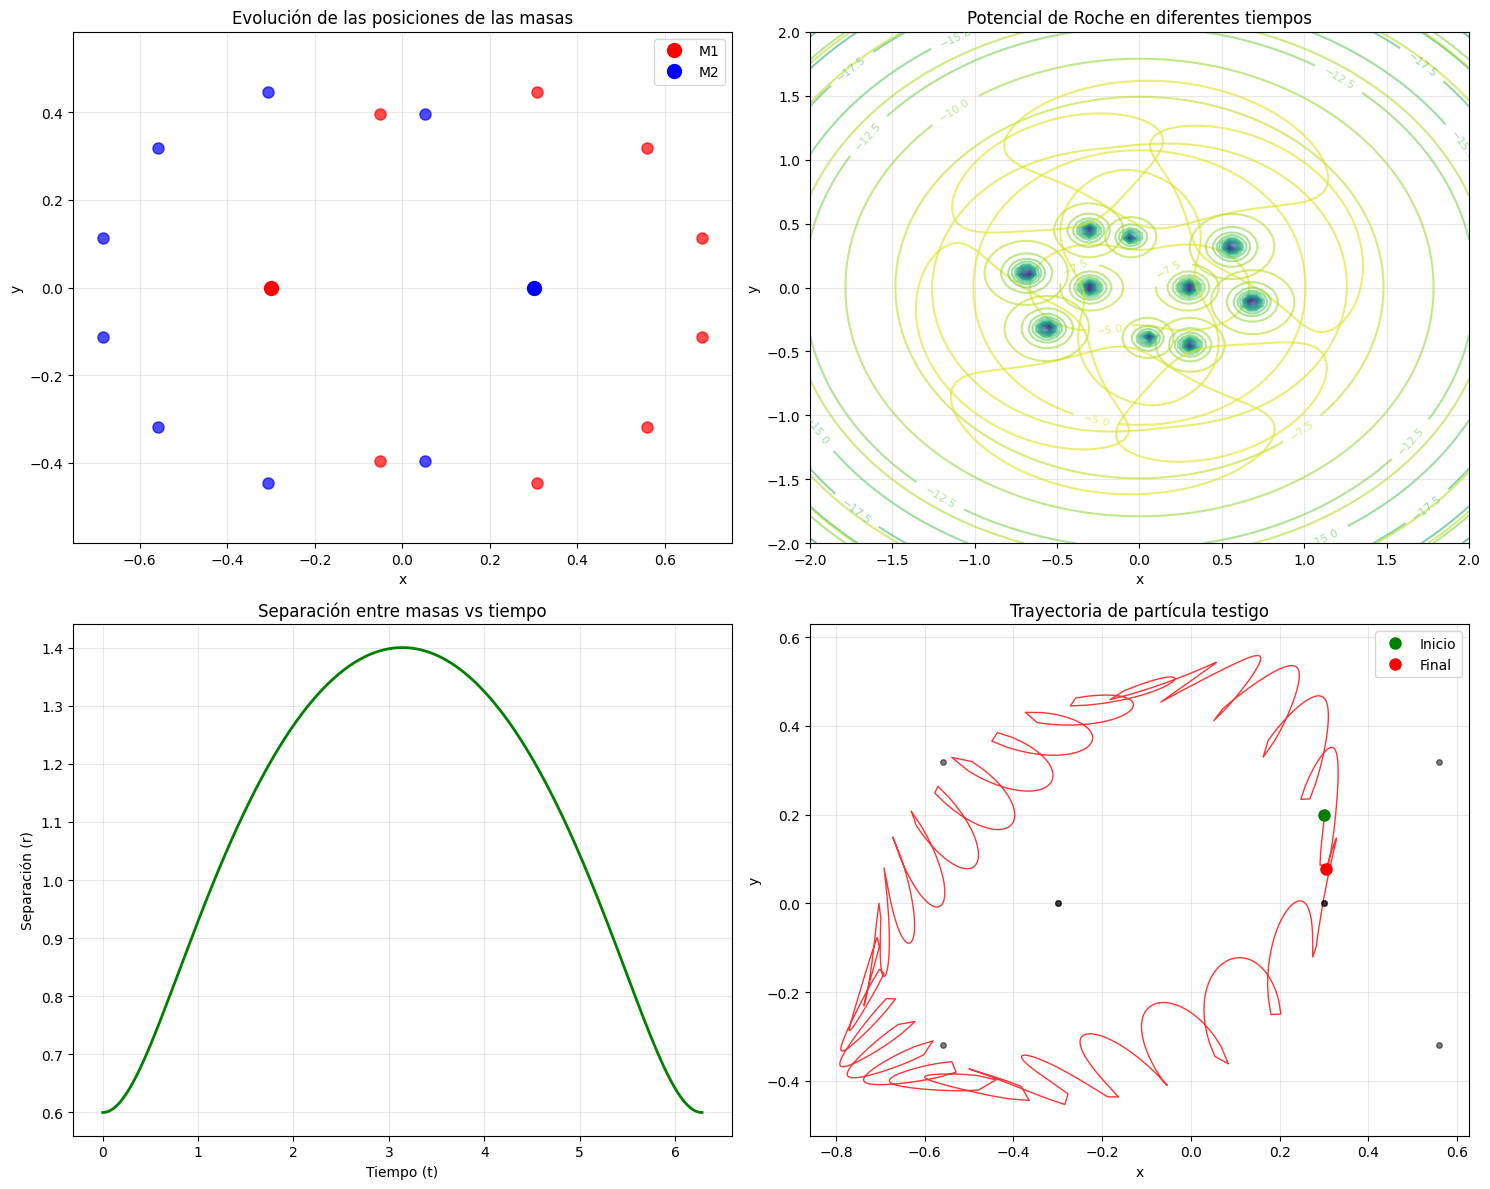

=== Análisis de Efectos de Excentricidad ===

Excentricidad e = 0.0:
  Separación mínima: 1.000
  Separación máxima: 1.000
  Variación relativa: 0.0%

Excentricidad e = 0.3:
  Separación mínima: 0.700
  Separación máxima: 1.298
  Variación relativa: 58.1%

Excentricidad e = 0.6:
  Separación mínima: 0.400
  Separación máxima: 1.597
  Variación relativa: 104.9%

Excentricidad e = 0.8:
  Separación mínima: 0.200
  Separación máxima: 1.797
  Variación relativa: 126.4%



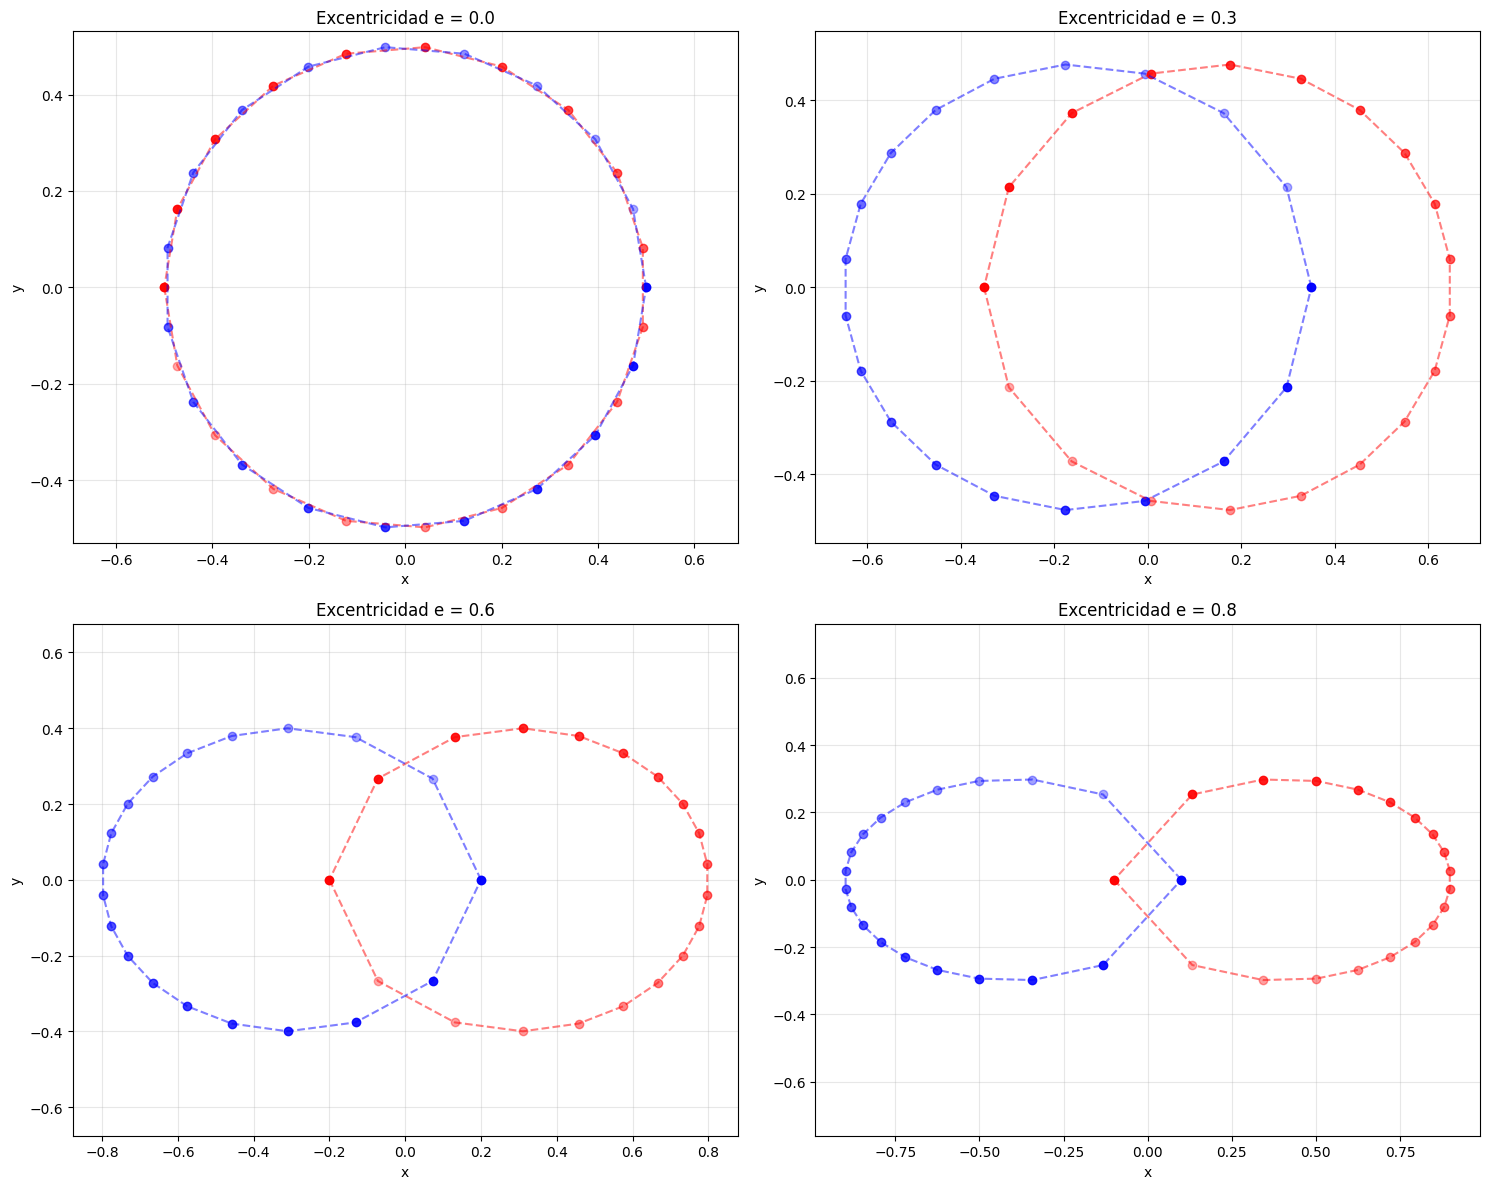

=== Simulación de Evolución de Trayectoria ===



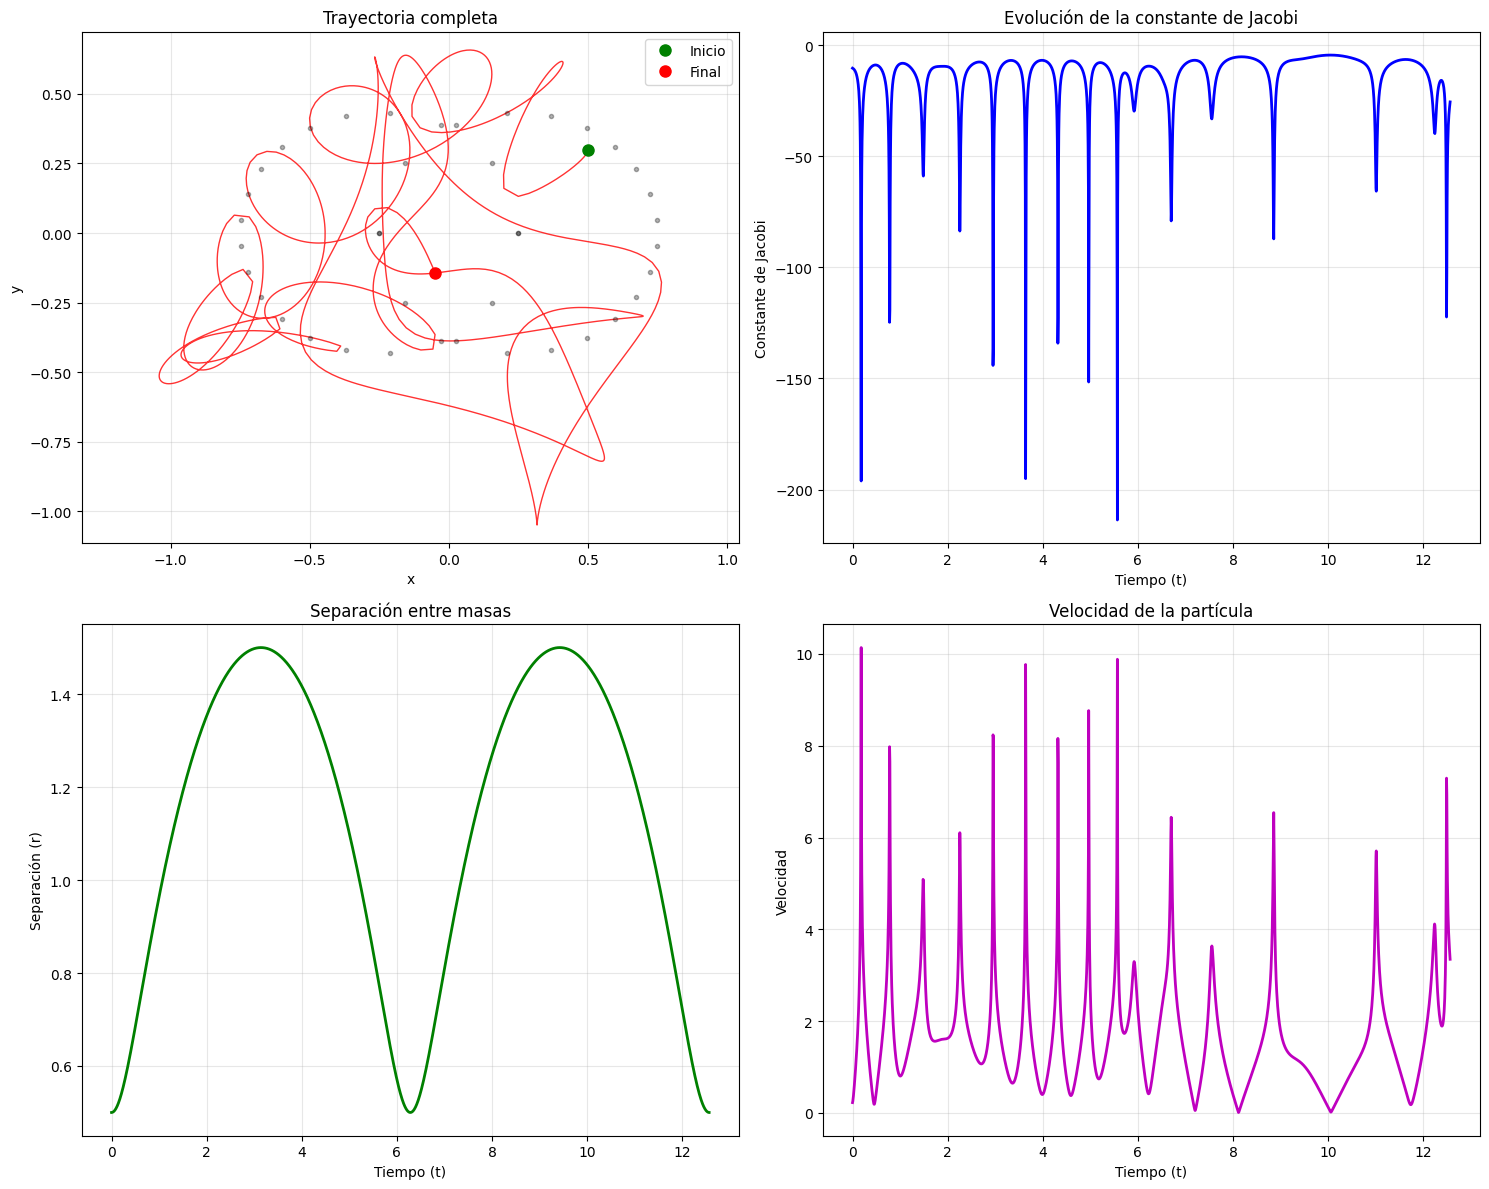

Constante de Jacobi:
  Media: -14.262254
  Desviación estándar: 15.900959
  Variación máxima: 209.222063

=== Resumen de Resultados ===
1. El sistema binario excéntrico modifica continuamente el potencial de Roche
2. Las posiciones de equilibrio varían con la fase orbital
3. La partícula testigo experimenta fuerzas variables que pueden llevar a:
   - Atrapamiento temporal en lóbulos
   - Escape del sistema en ciertos momentos orbitales
   - Resonancias con el movimiento orbital
4. La constante de Jacobi puede mostrar variaciones debido a los efectos no-inerciales


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import matplotlib.animation as animation

class EccentricBinarySystem:
    def __init__(self, q=1.0, a=1.0, e=0.0):
        """
        Inicializa el sistema binario excéntrico
        
        Parámetros:
        q: razón de masas M1/M2
        a: semieje mayor de la órbita
        e: excentricidad (0 <= e < 1)
        """
        self.q = q
        self.a = a
        self.e = e
        self.orbital_period = 2 * np.pi  # Período orbital normalizado
        
    def separation_distance(self, t):
        """
        Calcula la separación entre masas en función del tiempo
        usando la ecuación de órbita elíptica
        """
        # Anomalía media
        M = (2 * np.pi * t) / self.orbital_period
        
        # Resolver la ecuación de Kepler para la anomalía excéntrica E
        # M = E - e*sin(E)
        def kepler_eq(E):
            return E - self.e * np.sin(E) - M
        
        E = fsolve(kepler_eq, M)[0]
        
        # Anomalía verdadera
        theta = 2 * np.arctan(np.sqrt((1 + self.e)/(1 - self.e)) * np.tan(E/2))
        
        # Distancia radial
        r = self.a * (1 - self.e**2) / (1 + self.e * np.cos(theta))
        
        return r, theta
    
    def binary_positions(self, t):
        """
        Calcula las posiciones de M1 y M2 en función del tiempo
        """
        r, theta = self.separation_distance(t)
        
        # Posiciones en el sistema de coordenadas rotante
        # normalizado por la separación instantánea
        x1 = -r / (1 + self.q) * np.cos(theta)
        y1 = -r / (1 + self.q) * np.sin(theta)
        
        x2 = r * self.q / (1 + self.q) * np.cos(theta)
        y2 = r * self.q / (1 + self.q) * np.sin(theta)
        
        return np.array([x1, y1]), np.array([x2, y2])
    
    def roche_potential(self, x, y, t):
        """
        Calcula el potencial de Roche dependiente del tiempo
        """
        r1_pos, r2_pos = self.binary_positions(t)
        r, _ = self.separation_distance(t)
        
        # Distancias a cada masa
        r1_dist = np.sqrt((x - r1_pos[0])**2 + (y - r1_pos[1])**2)
        r2_dist = np.sqrt((x - r2_pos[0])**2 + (y - r2_pos[1])**2)
        
        # Potencial de Roche
        phi_R = (-self.q / r1_dist - 1 / r2_dist - 
                 0.5 * (1 + self.q) * (x**2 + y**2) / r**2)
        
        return phi_R
    
    def roche_potential_derivatives(self, x, y, t):
        """
        Calcula las derivadas del potencial de Roche
        """
        r1_pos, r2_pos = self.binary_positions(t)
        r, _ = self.separation_distance(t)
        
        # Distancias a cada masa
        r1_dist = np.sqrt((x - r1_pos[0])**2 + (y - r1_pos[1])**2)
        r2_dist = np.sqrt((x - r2_pos[0])**2 + (y - r2_pos[1])**2)
        
        # Derivadas parciales
        dphi_dx = (self.q * (x - r1_pos[0]) / r1_dist**3 + 
                   (x - r2_pos[0]) / r2_dist**3 + 
                   (1 + self.q) * x / r**2)
        
        dphi_dy = (self.q * (y - r1_pos[1]) / r1_dist**3 + 
                   (y - r2_pos[1]) / r2_dist**3 + 
                   (1 + self.q) * y / r**2)
        
        return dphi_dx, dphi_dy
    
    def equations_of_motion(self, t, state):
        """
        Ecuaciones de movimiento para la partícula testigo
        state = [x, y, vx, vy]
        """
        x, y, vx, vy = state
        
        # Derivadas del potencial
        dphi_dx, dphi_dy = self.roche_potential_derivatives(x, y, t)
        
        # Ecuaciones de movimiento con términos de Coriolis
        ax = -dphi_dx + 2 * vy
        ay = -dphi_dy - 2 * vx
        
        return [vx, vy, ax, ay]
    
    def integrate_trajectory(self, initial_conditions, t_span, t_eval=None):
        """
        Integra la trayectoria de la partícula testigo
        """
        if t_eval is None:
            t_eval = np.linspace(t_span[0], t_span[1], 1000)
        
        solution = solve_ivp(self.equations_of_motion, t_span, initial_conditions, 
                           t_eval=t_eval, method='RK45', rtol=1e-8)
        
        return solution
    
    def jacobi_constant(self, x, y, vx, vy, t):
        """
        Calcula la constante de Jacobi
        """
        phi_R = self.roche_potential(x, y, t)
        return 2 * phi_R - (vx**2 + vy**2)
    
    def find_lagrange_points(self, t):
        """
        Encuentra los puntos de Lagrange para un tiempo dado
        """
        def lagrange_equations(vars):
            x, y = vars
            dphi_dx, dphi_dy = self.roche_potential_derivatives(x, y, t)
            return [dphi_dx, dphi_dy]
        
        # Estimaciones iniciales para los puntos de Lagrange
        r1_pos, r2_pos = self.binary_positions(t)
        
        # L1: entre las masas
        x_guess = (r1_pos[0] + r2_pos[0]) / 2
        L1 = fsolve(lagrange_equations, [x_guess, 0])
        
        # L2: fuera de M2
        L2 = fsolve(lagrange_equations, [r2_pos[0] + 0.3, 0])
        
        # L3: fuera de M1
        L3 = fsolve(lagrange_equations, [r1_pos[0] - 0.3, 0])
        
        # L4 y L5: triángulos equiláteros
        center_x = (r1_pos[0] + r2_pos[0]) / 2
        center_y = (r1_pos[1] + r2_pos[1]) / 2
        separation = np.sqrt((r2_pos[0] - r1_pos[0])**2 + (r2_pos[1] - r1_pos[1])**2)
        
        L4 = fsolve(lagrange_equations, [center_x, center_y + separation * np.sqrt(3)/2])
        L5 = fsolve(lagrange_equations, [center_x, center_y - separation * np.sqrt(3)/2])
        
        return L1, L2, L3, L4, L5

def plot_eccentric_system_evolution(system, t_points, trajectory_ic=None):
    """
    Visualiza la evolución del sistema binario excéntrico
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Subplot 1: Evolución de las posiciones de las masas
    ax1 = axes[0, 0]
    for i, t in enumerate(t_points):
        r1_pos, r2_pos = system.binary_positions(t)
        ax1.plot(r1_pos[0], r1_pos[1], 'ro', markersize=8, alpha=0.7)
        ax1.plot(r2_pos[0], r2_pos[1], 'bo', markersize=8, alpha=0.7)
        
        if i == 0:
            ax1.plot(r1_pos[0], r1_pos[1], 'ro', label='M1', markersize=10)
            ax1.plot(r2_pos[0], r2_pos[1], 'bo', label='M2', markersize=10)
    
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Evolución de las posiciones de las masas')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    
    # Subplot 2: Potencial de Roche en diferentes tiempos
    ax2 = axes[0, 1]
    x_grid = np.linspace(-2, 2, 100)
    y_grid = np.linspace(-2, 2, 100)
    X, Y = np.meshgrid(x_grid, y_grid)
    
    for i, t in enumerate(t_points[::2]):  # Usar menos puntos para claridad
        Z = system.roche_potential(X, Y, t)
        contour = ax2.contour(X, Y, Z, levels=20, alpha=0.6)
        if i == 0:
            ax2.clabel(contour, inline=True, fontsize=8)
    
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title('Potencial de Roche en diferentes tiempos')
    ax2.grid(True, alpha=0.3)
    
    # Subplot 3: Separación entre masas vs tiempo
    ax3 = axes[1, 0]
    t_continuous = np.linspace(0, 2*np.pi, 1000)
    separations = [system.separation_distance(t)[0] for t in t_continuous]
    ax3.plot(t_continuous, separations, 'g-', linewidth=2)
    ax3.set_xlabel('Tiempo (t)')
    ax3.set_ylabel('Separación (r)')
    ax3.set_title('Separación entre masas vs tiempo')
    ax3.grid(True, alpha=0.3)
    
    # Subplot 4: Trayectoria de partícula testigo (si se proporciona)
    ax4 = axes[1, 1]
    if trajectory_ic is not None:
        t_span = (0, 2*np.pi)
        t_eval = np.linspace(0, 2*np.pi, 1000)
        sol = system.integrate_trajectory(trajectory_ic, t_span, t_eval)
        
        ax4.plot(sol.y[0], sol.y[1], 'r-', linewidth=1, alpha=0.8)
        ax4.plot(sol.y[0][0], sol.y[1][0], 'go', markersize=8, label='Inicio')
        ax4.plot(sol.y[0][-1], sol.y[1][-1], 'ro', markersize=8, label='Final')
        
        # Agregar posiciones de las masas en algunos tiempos
        for t in t_points[::3]:
            r1_pos, r2_pos = system.binary_positions(t)
            ax4.plot(r1_pos[0], r1_pos[1], 'ko', markersize=4, alpha=0.5)
            ax4.plot(r2_pos[0], r2_pos[1], 'ko', markersize=4, alpha=0.5)
    
    ax4.set_xlabel('x')
    ax4.set_ylabel('y')
    ax4.set_title('Trayectoria de partícula testigo')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.axis('equal')
    
    plt.tight_layout()
    plt.show()

def analyze_eccentric_effects():
    """
    Análisis de los efectos de la excentricidad en el sistema
    """
    print("=== Análisis de Efectos de Excentricidad ===\n")
    
    # Crear sistemas con diferentes excentricidades
    eccentricities = [0.0, 0.3, 0.6, 0.8]
    systems = [EccentricBinarySystem(q=1.0, a=1.0, e=e) for e in eccentricities]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, (e, system) in enumerate(zip(eccentricities, systems)):
        ax = axes[i]
        
        # Tiempo para un período orbital completo
        t_points = np.linspace(0, 2*np.pi, 20)
        
        # Plotear las posiciones de las masas
        for j, t in enumerate(t_points):
            r1_pos, r2_pos = system.binary_positions(t)
            alpha = 0.3 + 0.7 * j / len(t_points)
            ax.plot(r1_pos[0], r1_pos[1], 'ro', markersize=6, alpha=alpha)
            ax.plot(r2_pos[0], r2_pos[1], 'bo', markersize=6, alpha=alpha)
        
        # Conectar las posiciones para mostrar la órbita
        r1_positions = np.array([system.binary_positions(t)[0] for t in t_points])
        r2_positions = np.array([system.binary_positions(t)[1] for t in t_points])
        
        ax.plot(r1_positions[:, 0], r1_positions[:, 1], 'r--', alpha=0.5)
        ax.plot(r2_positions[:, 0], r2_positions[:, 1], 'b--', alpha=0.5)
        
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f'Excentricidad e = {e:.1f}')
        ax.grid(True, alpha=0.3)
        ax.axis('equal')
        
        # Análisis cuantitativo
        separations = [system.separation_distance(t)[0] for t in t_points]
        print(f"Excentricidad e = {e:.1f}:")
        print(f"  Separación mínima: {min(separations):.3f}")
        print(f"  Separación máxima: {max(separations):.3f}")
        print(f"  Variación relativa: {(max(separations) - min(separations))/np.mean(separations)*100:.1f}%\n")
    
    plt.tight_layout()
    plt.show()

def simulate_trajectory_evolution():
    """
    Simula la evolución de una trayectoria en un sistema excéntrico
    """
    print("=== Simulación de Evolución de Trayectoria ===\n")
    
    # Sistema con excentricidad moderada
    system = EccentricBinarySystem(q=1.0, a=1.0, e=0.5)
    
    # Condiciones iniciales de la partícula testigo
    initial_conditions = [0.5, 0.3, 0.1, -0.2]
    
    # Integrar la trayectoria
    t_span = (0, 4*np.pi)  # Dos períodos orbitales
    t_eval = np.linspace(0, 4*np.pi, 2000)
    
    solution = system.integrate_trajectory(initial_conditions, t_span, t_eval)
    
    # Calcular la constante de Jacobi a lo largo de la trayectoria
    jacobi_constants = []
    for i in range(len(solution.t)):
        t = solution.t[i]
        x, y, vx, vy = solution.y[:, i]
        cj = system.jacobi_constant(x, y, vx, vy, t)
        jacobi_constants.append(cj)
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Trayectoria completa
    ax1 = axes[0, 0]
    ax1.plot(solution.y[0], solution.y[1], 'r-', linewidth=1, alpha=0.8)
    ax1.plot(solution.y[0][0], solution.y[1][0], 'go', markersize=8, label='Inicio')
    ax1.plot(solution.y[0][-1], solution.y[1][-1], 'ro', markersize=8, label='Final')
    
    # Agregar posiciones de las masas en algunos tiempos
    time_samples = np.linspace(0, 4*np.pi, 20)
    for t in time_samples:
        r1_pos, r2_pos = system.binary_positions(t)
        ax1.plot(r1_pos[0], r1_pos[1], 'ko', markersize=3, alpha=0.3)
        ax1.plot(r2_pos[0], r2_pos[1], 'ko', markersize=3, alpha=0.3)
    
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Trayectoria completa')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    
    # Constante de Jacobi vs tiempo
    ax2 = axes[0, 1]
    ax2.plot(solution.t, jacobi_constants, 'b-', linewidth=2)
    ax2.set_xlabel('Tiempo (t)')
    ax2.set_ylabel('Constante de Jacobi')
    ax2.set_title('Evolución de la constante de Jacobi')
    ax2.grid(True, alpha=0.3)
    
    # Separación entre masas vs tiempo
    ax3 = axes[1, 0]
    separations = [system.separation_distance(t)[0] for t in solution.t]
    ax3.plot(solution.t, separations, 'g-', linewidth=2)
    ax3.set_xlabel('Tiempo (t)')
    ax3.set_ylabel('Separación (r)')
    ax3.set_title('Separación entre masas')
    ax3.grid(True, alpha=0.3)
    
    # Velocidad de la partícula vs tiempo
    ax4 = axes[1, 1]
    velocities = np.sqrt(solution.y[2]**2 + solution.y[3]**2)
    ax4.plot(solution.t, velocities, 'm-', linewidth=2)
    ax4.set_xlabel('Tiempo (t)')
    ax4.set_ylabel('Velocidad')
    ax4.set_title('Velocidad de la partícula')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Análisis estadístico
    print(f"Constante de Jacobi:")
    print(f"  Media: {np.mean(jacobi_constants):.6f}")
    print(f"  Desviación estándar: {np.std(jacobi_constants):.6f}")
    print(f"  Variación máxima: {max(jacobi_constants) - min(jacobi_constants):.6f}")
    
    return solution

# Ejemplo de uso
if __name__ == "__main__":
    # Crear un sistema binario excéntrico
    system = EccentricBinarySystem(q=1.0, a=1.0, e=0.4)
    
    # Puntos de tiempo para el análisis
    t_points = np.linspace(0, 2*np.pi, 10)
    
    # Condiciones iniciales para una partícula testigo
    trajectory_ic = [0.3, 0.2, 0.05, -0.1]
    
    # Visualizar la evolución del sistema
    plot_eccentric_system_evolution(system, t_points, trajectory_ic)
    
    # Análizar efectos de diferentes excentricidades
    analyze_eccentric_effects()
    
    # Simular evolución de trayectoria
    solution = simulate_trajectory_evolution()
    
    print("\n=== Resumen de Resultados ===")
    print("1. El sistema binario excéntrico modifica continuamente el potencial de Roche")
    print("2. Las posiciones de equilibrio varían con la fase orbital")
    print("3. La partícula testigo experimenta fuerzas variables que pueden llevar a:")
    print("   - Atrapamiento temporal en lóbulos")
    print("   - Escape del sistema en ciertos momentos orbitales")
    print("   - Resonancias con el movimiento orbital")
    print("4. La constante de Jacobi puede mostrar variaciones debido a los efectos no-inerciales")

### Análisis físico

Se modela la evolución física de un sistema binario excéntrico donde las dos masas, \(M_1\) y \(M_2\), orbitan mutuamente con una separación que varía periódicamente en el tiempo según las leyes de Kepler. A través del cálculo del potencial de Roche dependiente del tiempo y la integración de las ecuaciones de movimiento de una partícula testigo, se exploran fenómenos físicos como el efecto de la excentricidad en la estabilidad del sistema, el desplazamiento de los puntos de Lagrange, y el comportamiento de la constante de Jacobi. La excentricidad introduce variaciones en la geometría del potencial gravitacional y en las fuerzas centrífugas y de marea que actúan sobre la partícula, modificando su trayectoria y la posibilidad de escape, resonancia o captura. Este modelo permite estudiar situaciones realistas en astrofísica como binarias con órbitas elípticas, sistemas en interacción cercana, o escenarios de acreción y eyección en estrellas variables o progenitoras de supernovas, donde las condiciones dinámicas cambian a lo largo del ciclo orbital.


## Conclusión

A lo largo de este trabajo se ha desarrollado un modelo físico y computacional robusto para estudiar la dinámica de una partícula testigo en sistemas binarios mediante el potencial de Roche. Este enfoque ha permitido no solo comprender de forma cualitativa las estructuras de equilibrio gravitacional —representadas por los puntos de Lagrange—, sino también cuantificar su estabilidad y evolución bajo diversas condiciones astrofísicas. Se analizaron casos con masas constantes, transferencias de masa simuladas mediante funciones temporales de la razón de masas \( q(t) \), y se visualizaron los cambios topológicos que esto implica en el potencial efectivo. 

Además, se incorporó el análisis mediante la constante de Jacobi para identificar regiones prohibidas y cuellos de escape, abriendo paso a la interpretación de fenómenos como la transferencia de masa y la posible eyección del sistema. Los resultados obtenidos muestran la rica variedad dinámica que puede emerger en un sistema binario, desde configuraciones cerradas y confinadas hasta regímenes de escape y atrapamiento transitorio. Este modelo, aunque simplificado, captura de forma clara la física esencial que subyace en sistemas binarios de interés astrofísico, como binarias de contacto, binarias X o incluso progenitores de supernovas tipo Ia.

En resumen, el trabajo no solo aporta una comprensión conceptual profunda, sino que también provee una herramienta flexible y extensible para futuros estudios sobre evolución binaria, transferencia de masa y estabilidad orbital. La riqueza de estructuras que emergen del simple cambio en \( q(t) \) y la posibilidad de expandir el modelo a órbitas excéntricas o discos de acreción abre un abanico de posibilidades para extender esta investigación hacia escenarios más realistas y astrofísicamente relevantes.


## Perspectivas futuras

Aun con la riqueza de resultados obtenidos, el potencial de Roche y la dinámica de sistemas binarios siguen siendo un terreno fértil para preguntas sin resolver y oportunidades de investigación:

1. **Modelos 3D con hidrodinámica y radiación**  
   Pasar de la aproximación plana a simulaciones tridimensionales que acoplen la ecuación de Euler con transporte radiativo permitirá seguir, en tiempo real, la formación de discos de acreción, chorros y eyecciones de masa. Esto es crucial para vincular la teoría con observaciones multi-longitud de onda (radio, óptico y rayos X).

2. **Campos magnéticos y MHD**  
   Incluir magnetohidrodinámica (MHD) en el marco de Roche revelará cómo los campos magnéticos canalizan el flujo de material a través de \(L_1\), modifican la estructura del disco y quizá expliquen la colimación de jets relativistas en micro-cuásares.

3. **Retroalimentación de viento estelar y pérdida de momento angular**  
   Los modelos actuales tratan los vientos como términos externos; un tratamiento autoconsistente podría predecir cuándo la transferencia de masa se vuelve inestable, derivando en comunes envolturas o fusiones estelares —etapas clave para progenitores de supernovas Ia y binarias de ondas gravitacionales.

4. **Acoplamiento con evolución estelar detallada**  
   Integrar códigos de evolución estelar (p.ej., MESA) con el potencial de Roche variable permitirá rastrear, ciclo a ciclo, cómo la quema nuclear interna y la masa transferida se retroalimentan, alterando órbitas y rotaciones.

5. **Regímenes de alta excentricidad y capturas dinámicas**  
   Explorar sistemas con \(e \gtrsim 0.8\) —relevantes en entornos densos como cúmulos globulares— podría desvelar rutas exóticas hacia fusiones de objetos compactos, generadoras de estallidos de ondas gravitacionales y kilonovas.

6. **Machine Learning y ajuste de parámetros**  
   Con grandes catálogos de binarias (Gaia, LSST) a la vista, técnicas de ML pueden invertir observables (curvas de luz, espectros) para derivar \(q(t)\), tasas de acreción y geometrías de lóbulos, abriendo la puerta a “mapear” poblaciones completas de binarias.

7. **Pruebas con observaciones de alta cadencia**  
   Telescopios como Rubin/LSST y misiones de rayos X de nueva generación ofrecerán datos de alta cadencia que pondrán a prueba —en tiempo casi real— las predicciones de inestabilidad y variabilidad del potencial de Roche en sistemas interactivos.

En conjunto, estas líneas prometen consolidar el puente entre el refinamiento teórico del potencial de Roche y la observación de fenómenos transitorios —desde estallidos de nova hasta fusiones de agujeros negros—, llevando nuestra comprensión de las binarias a un nivel predictivo verdaderamente integral.


# Referencias

### Referencias

El Mellah, I., Sundqvist, J. O., & Keppens, R. (2017). *An introduction to close binary stars and mass transfer*. arXiv. https://arxiv.org/abs/1707.09165


Frank, J., King, A., & Raine, D. J. (2002). *Accretion power in astrophysics* (3rd ed.). Cambridge University Press.  


Hilditch, R. W. (2001). *An introduction to close binary stars*. Cambridge University Press.  


